# CSC3831 Final Assessment - Part I: Data Engineering

##Import Libraries

In [ ]:
import random
import math
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from scipy.stats import skew, ks_2samp
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

## 1. Data Understanding

**Exploratory Data Analysis (EDA)** involves examining the surface properties of a dataset using visualisation and statistical techniques. It is an important initial step in data analysis as it validates the data's authenticity and ensures there are no obvious errors or inconsistencies (*Pratik, 2025*).

###1.1 Inspect Data Set

To gain a better understanding of the dataset, we can print the first few rows. This allows us to inspect the various attributes and observe the data types present in `houses_corrupted`.

In [ ]:
houses_corrupted.head(10)

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   
5            269700.0         4.0368                52.0        919.0   
6            299200.0         3.6591                52.0       2535.0   
7            241400.0         3.1200                52.0       3104.0   
8            226700.0         2.0804                42.0       2555.0   
9            261100.0         3.6912                52.0       3549.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1          1106.0      2401.0      1138.0     37.86    -122.22  
2           190.0         NaN       177.0     37.85    -122.24  
3           235.0         NaN       219.0     37.85    -122.25  
4           280.0       565.0       259.0     37.85    -122.25  
5           213.0       413.0       193.0     37.85    -122.25  
6           489.0      1094.0       514.0     37.84    -122.25  
7           687.0      1157.0       647.0     37.84    -122.25  
8           665.0      1206.0       595.0     37.84    -122.26  
9           707.0      1551.0       714.0     37.84    -122.25

The dataset contains **9 numerical attributes** and an index column. These attributes provide information about housing and population statistics for specific geographic areas, defined by the `latitude` and `longitude` columns.

*   `median_house_value:` The median house price in the area.
*   `median_income:` The median income of residents in the area.
*   `housing_median_age:` The median age of housing structures in the area.
*   `total_rooms:` The total number of rooms in all housing units within the area.
*   `total_bedrooms:` The total number of bedrooms in all housing units within the area.
*   `population:` The total number of people living in the area.
*   `households:` The total number of individual housing units in the area.
*   `latitude` and `longitude:` Geographic coordinates identifying the location of each data point.

In [ ]:
houses_corrupted.shape

(20640, 9)

The dataset contains **20,640 rows** and **9 attributes**, as shown by `houses_corrupted.shape`. This indicates that the dataset has 20,640 individual records and 9 features describing each record. Understanding the dataset's size is important for assessing **computational requirements** and deciding which types of analysis are appropriate for the data.

In [ ]:
houses_corrupted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


`houses_corrupted.info()` shows that all attributes are of type **float** and each column contains **20,640** entries, with `median_income`, `housing_median_age`, and `population` missing approximately 10% of their data. Its consistent numeric structure makes it well-suited for statistical and machine learning tasks after handling the missing data.

In [ ]:
houses_corrupted.describe()

median_house_value  median_income  housing_median_age   total_rooms  \
count        20640.000000   18576.000000        18576.000000  20640.000000   
mean        206855.816909       3.929958           28.324182   2635.763081   
std         115395.615874       1.964296           12.584914   2181.615252   
min          14999.000000       0.499900            1.000000      2.000000   
25%         119600.000000       2.560300           18.000000   1447.750000   
50%         179700.000000       3.572400           28.000000   2127.000000   
75%         264725.000000       4.870050           37.000000   3148.000000   
max         500001.000000      15.000100           52.000000  39320.000000   

       total_bedrooms    population    households      latitude     longitude  
count    20640.000000  18576.000000  20640.000000  20640.000000  20640.000000  
mean       537.898014   1488.069283    499.539680     35.631861   -119.569704  
std        421.247906   1170.585810    382.329753      2.135952      2.003532  
min          1.000000      3.000000      1.000000     32.540000   -124.350000  
25%        295.000000    839.000000    280.000000     33.930000   -121.800000  
50%        435.000000   1227.000000    409.000000     34.260000   -118.490000  
75%        647.000000   1803.000000    605.000000     37.710000   -118.010000  
max       6445.000000  35682.000000   6082.000000     41.950000   -114.310000

The `.describe()` method reveals important insights into the statistical values for each column showing aspects such as central tendency, dispersion and shape of a dataset's distribution.

The **standard deviation** indicates high variability in the dataset, particularly in the `median_house_value`, `total_rooms`, `total_bedrooms`, and `population` columns. This suggests a range of both high and low property values, as well as varying population densities. In contrast, the `latitude` and `longitude` columns show lower standard deviations, suggesting that the data is geographically concentrated in a specific region.

Another observation is that for some columns (e.g. `median_house_value` and `total_rooms`), the **mean** is higher than the **median**. This indicates that high-value outliers are likely pulling the mean upwards, suggesting a **skew** in the data for these columns. This observation is further supported by the large standard deviation in these columns, which can be caused by outliers or extreme values that deviate significantly from the **central tendency** of the data.

####1.1.1 Check for Missing Values

During the data inspection, it was apparent that the dataset contains missing values. Identifying missing data is essential because many machine learning algorithms cannot process it directly, leading to potential errors or biases. Detecting missing values allows for informed decisions on handling them, ensuring **accurate** and **reliable** results.

In [ ]:
houses_corrupted.isnull().sum()

median_house_value       0
median_income         2064
housing_median_age    2064
total_rooms              0
total_bedrooms           0
population            2064
households               0
latitude                 0
longitude                0
dtype: int64

As shown above, the columns `median_income`, `housing_median_age`, and `population` all contain missing values.

For `median_income`, it's possible that some survey respondents chose not to disclose their income due to privacy concerns, which could explain the missing records. In the case of `housing_median_age`, the missing values might result from a lack of historical housing data in newly developed areas. For `population`, the missing data could be the result of sampling errors during data collection.

Interestingly, all three columns with missing data have the same number of missing entries. This suggests a potential common cause for the missing values, such as data loss during the integration of datasets.

<Axes: >

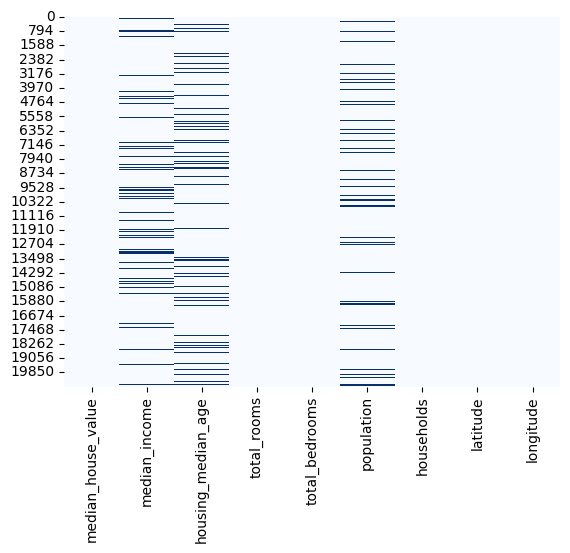

In [ ]:
sns.heatmap(houses_corrupted.isnull(), cbar=False, cmap='Blues', annot=False)

The heatmap indicates that missing values are fairly distributed across the dataset, with notable concentrations in the `median_income` and `population` columns around specific rows (9528, 10322, 12704, and 13498). This suggests that the missing values may not be entirely random. To address this, **imputation** techniques can be applied to prepare the dataset for further analysis. Alternatively, rows or columns with significant missing data may be removed if necessary.

###1.2 Visualise Data

####1.2.1 Histograms

Next, we can plot a **histogram** for each column to visualise the distribution of our data. This allows us to analyse the shape, spread, and variability, making it easier to identify **skewness** and detect **outliers** in the dataset (Leung, 2019). Understanding these characteristics is important for choosing appropriate measures of central tendency and spread, as skewed data can distort certain statistics and lead to inaccurate conclusions. Since our dataset consists entirely of numerical columns, histograms are an ideal choice for examining all features at once.

When creating a histogram, the choice of bin size is equally important for effective visualisation. A large bin size can oversimplify the data, hiding important details, while too many bins can make the plot noisy and difficult to interpret. I experimented with bin sizes ranging from 20 to 100 and found 50 to provide the best balance.

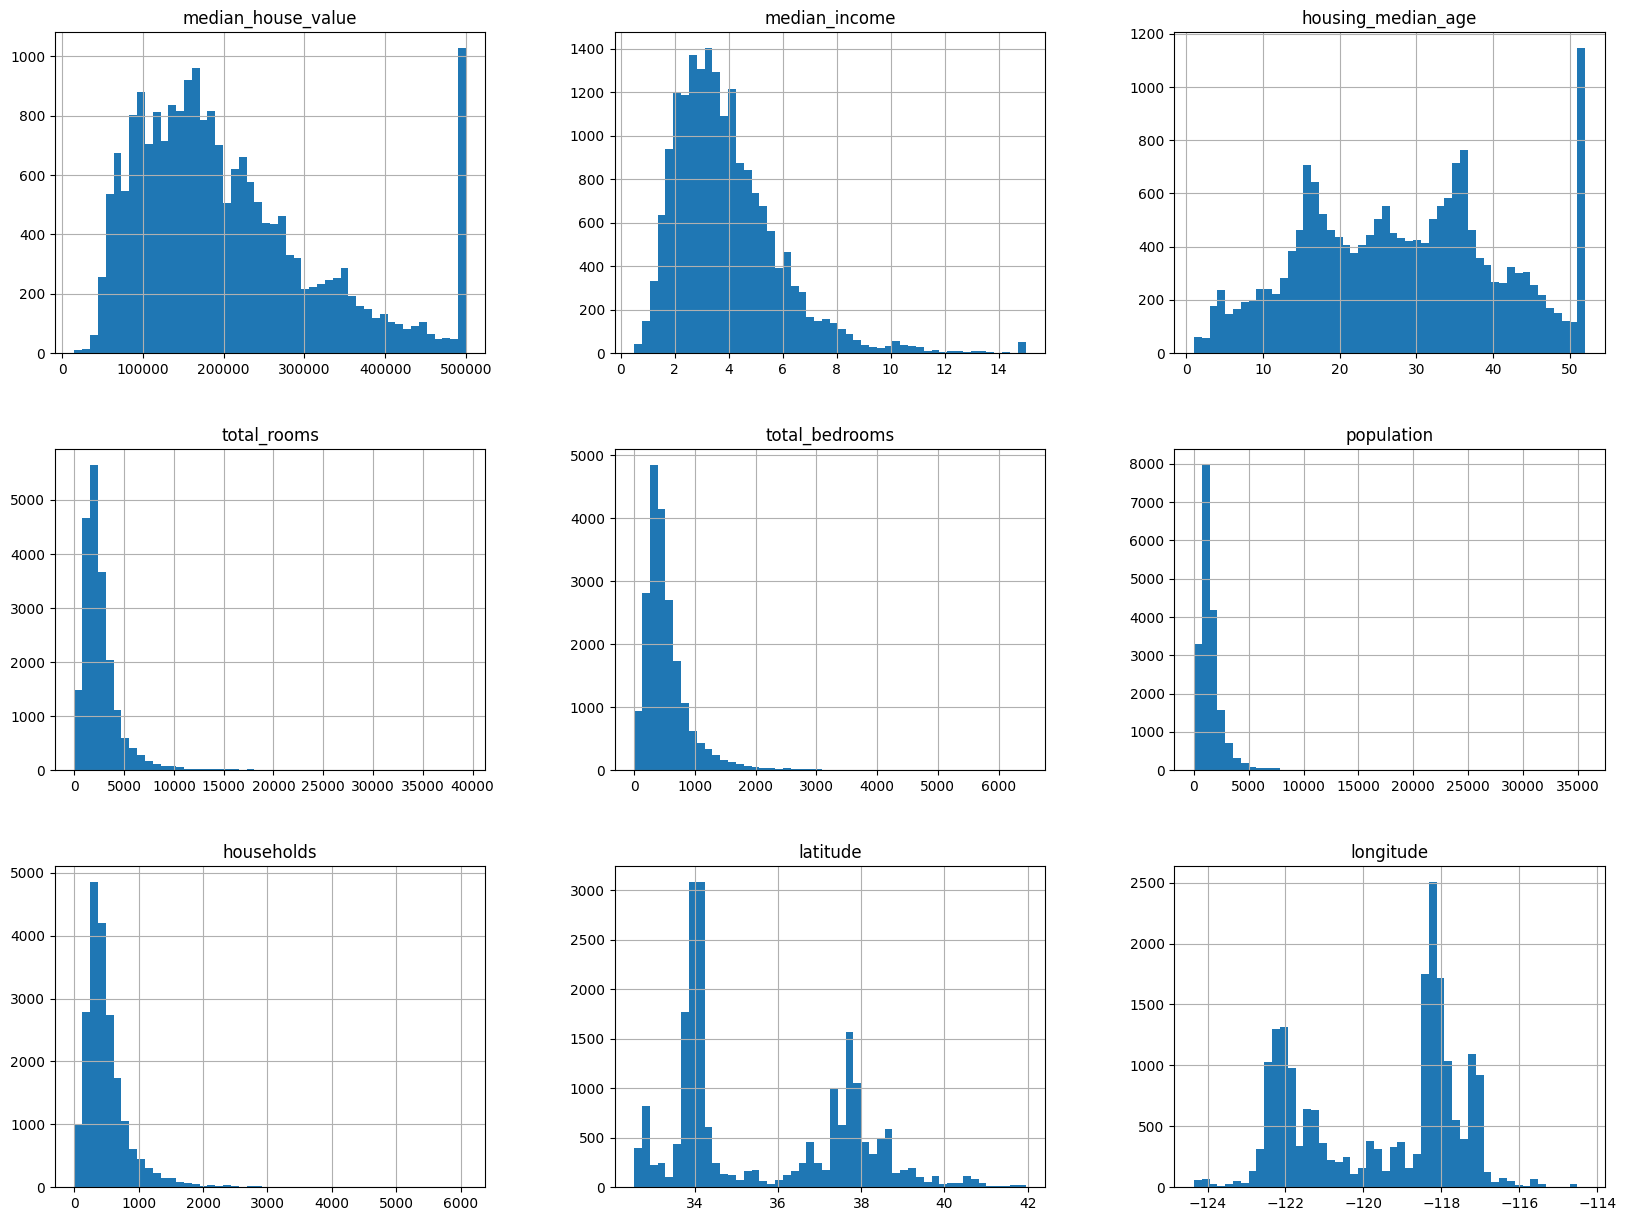

In [ ]:
# Generate histograms for the dataset
houses_corrupted.hist(bins=50, figsize=(20, 15))

# Display the plot
plt.show()

The density plots show that `median_house_value`, `median_income`, `total_rooms`, `total_bedrooms`, `households` and `population` have a positive skew, making the **median** and **MAD** the best measures for center and spread. `Longitude` has a mild negative skew and `latitude` as a mild positive skew, so either the **mean** or **median** can be used, depending on the impact of outliers. Both `longitude` and `latitude` display a **bimodal distribution**, suggesting the data is clustered into two distinct geographic regions.

The histogram reveals that `median_house_value` has most house prices concentrated at the lower end of the distribution. However, there is a noticeable spike at the **500,000 mark**, suggesting that the dataset has likely been capped at this value. This assumption is confirmed by the maximum value of median_house_value, which is 500,001. This cap could present challenges in future analyses, as it underrepresents higher-priced homes and may skew predictions and insights. A similar issue is observed with `housing_median_age`, where values also appear capped. This could hinder a machine learning algorithm's ability to learn accurately, as it may infer that `median_house_value` and `housing_median_age` never exceed these limits. Additionally, the dataset's columns have significantly different scales, which could negatively impact certain machine learning algorithms. To address this, it will be important to scale the data later on in the process.

In [ ]:
houses_corrupted.skew()

median_house_value    0.977763
median_income         1.587611
housing_median_age    0.085426
total_rooms           4.147343
total_bedrooms        3.453073
population            4.825861
households            3.410438
latitude              0.465953
longitude            -0.297801
dtype: float64

To further confirm the distribution of each column, the skewness has been calculated. From this, we observe that `median_house_value`, `median_income`, `total_rooms`, `total_bedrooms`, and `population` exhibit a **positive skew**, with `total_rooms` and `population` showing a particularly **strong skew**. In contrast, `housing_median_age` has a skewness close to zero, suggesting that the data is fairly evenly distributed. Finally, `latitude` shows a slight **positive skew**, while `longitude` has a slight **negative skew**. This approach was particularly efficient, as it was more difficult to identify skewness for longitude and latitude by looking at the histograms alone.

####1.2.2 Boxplots

**Boxplots** are a useful way to visualise the data and identify outliers, which is important because outliers can distort statistical analysis and affect the accuracy of models. Additionally, boxplots show how tightly the data is grouped and can reveal whether the data is skewed.

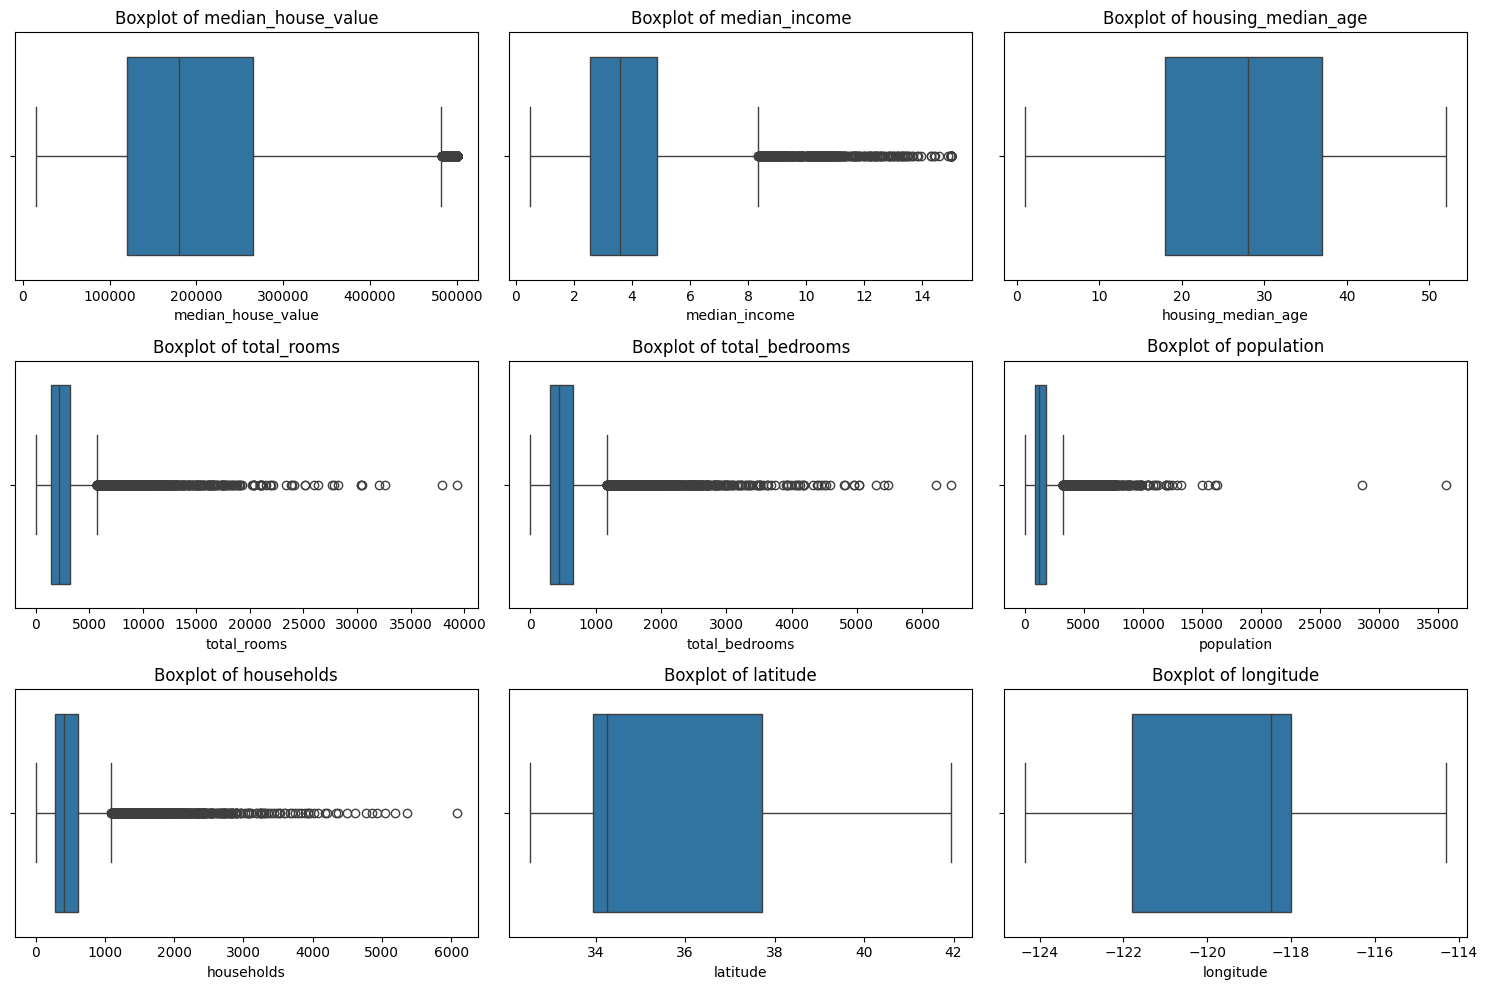

In [ ]:
# Set the figure size of the boxplots
plt.figure(figsize=(15, 10))

# Create a boxplot for each column
for i, column in enumerate(houses_corrupted.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=houses_corrupted[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

The boxplots reveal the presence of **outliers** in `median_house_value`, `median_income`, `total_rooms`, `total_bedrooms`, and `population`, as indicated by the dots positioned beyond the **upper whisker**. Several columns, including `median_income`, `total_rooms`, `total_bedrooms`, `population`, and households, show a significant number of outliers, which is often a result of the data being **skewed**. Examining the position of the **median** line within each box, we observe that `median_house_value`, `median_income`, `total_rooms`, `total_bedrooms`, `population`, and `latitude` have median lines closer to the bottom of the box, indicating positive skewness. Similarly, the median line for `longitude` is closer to the left of the box, suggesting a negative skew.

In addition, the spread of the data is very concentrated in `total_rooms`, `total_bedrooms`, `population`, and `households`, as indicated by the narrow range between the **lower and upper whiskers**. This suggests that the data points in these columns are closely clustered, reflecting low variability within the central 50% of the data.

This information is important for determining which columns require outlier handling and for selecting the appropriate approaches based on the skewness of each column.

###1.3 Correlation and Relationships

We will examine the correlations between the attributes to uncover relationships and understand how they influence each other.

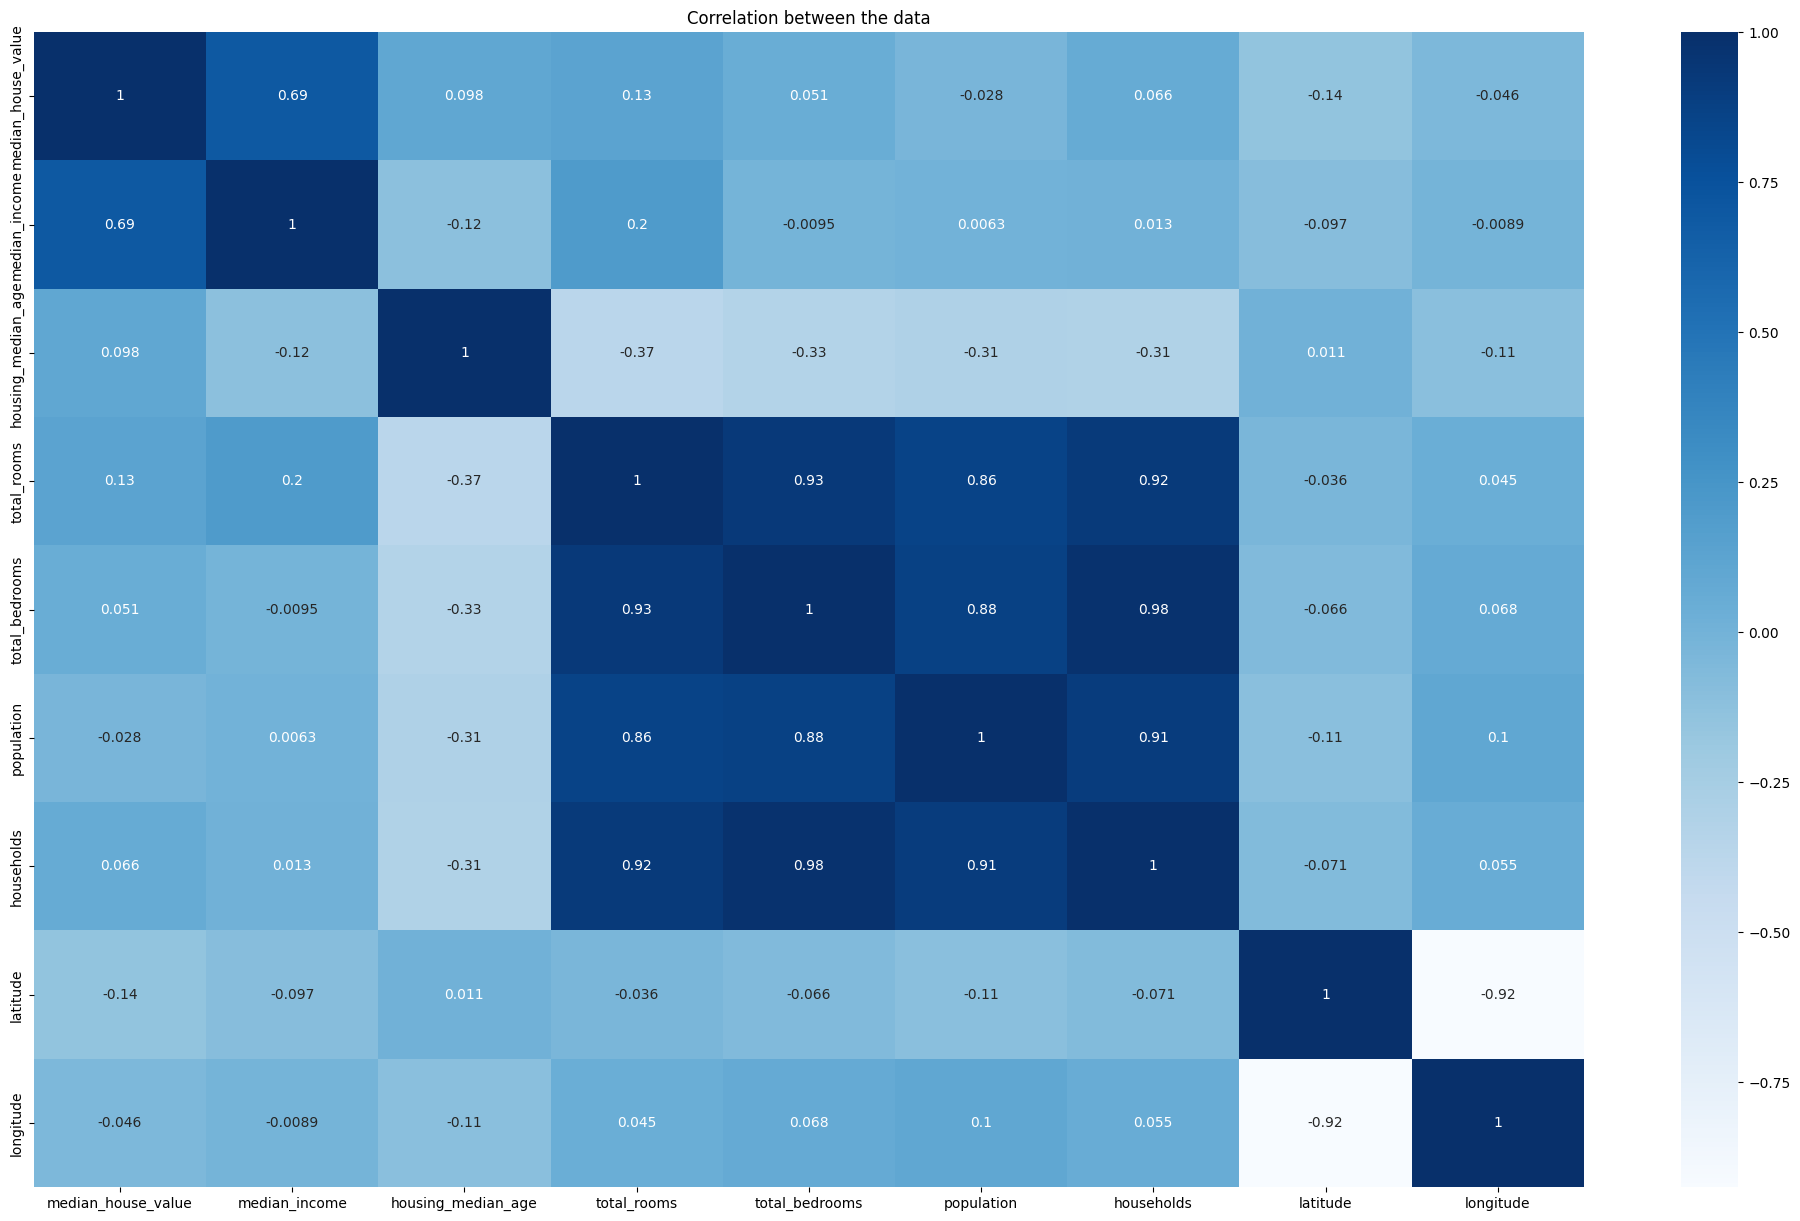

In [ ]:
# Heatmap for obeserving correlations
plt.figure(figsize=(25,15))
california_heatmap = houses_corrupted.corr()

sns.heatmap(california_heatmap, annot=True, cmap='Blues').set(
    title = "Correlation between the data"
)

plt.xticks(rotation=360)
plt.show()

The **correlations** calculated show several important relationships within the dataset. There is a **strong positive correlation** between `total_rooms`, `total_bedrooms`, `households`, and `population`, indicating that areas with more rooms and bedrooms tend to also have more households and a higher population density. Similarly, there is a **moderate positive correlation** between `median_income` and `median_house_value`, showing that higher-income areas tend to have more expensive houses. In contrast, there is a **weak negative correlation** between `population` and `median_house_value`, as well as between `housing_median_age` and other variables, implying that factors such as population size may not significantly affect house values. Additionally, `longitude` and `latitude` have a **strong negative correlation**, which likely reflects the spatial pattern of the region. By examining these correlations, we can determine which variables are closely related and which ones are independent, which is crucial for uncovering potential **trends and patterns** for further analysis.

####1.3.1 Scatter plots

We can use a scatter plot to visually confirm the relationships highlighted in the **heatmap**. The scatter plot also helps identify trends, clusters, and potential outliers, offering a clearer understanding of how the compared attributes influence each other. We can look at the different relationships `median_house_value` has with other attributes as this will be the column that we will later be predicting.

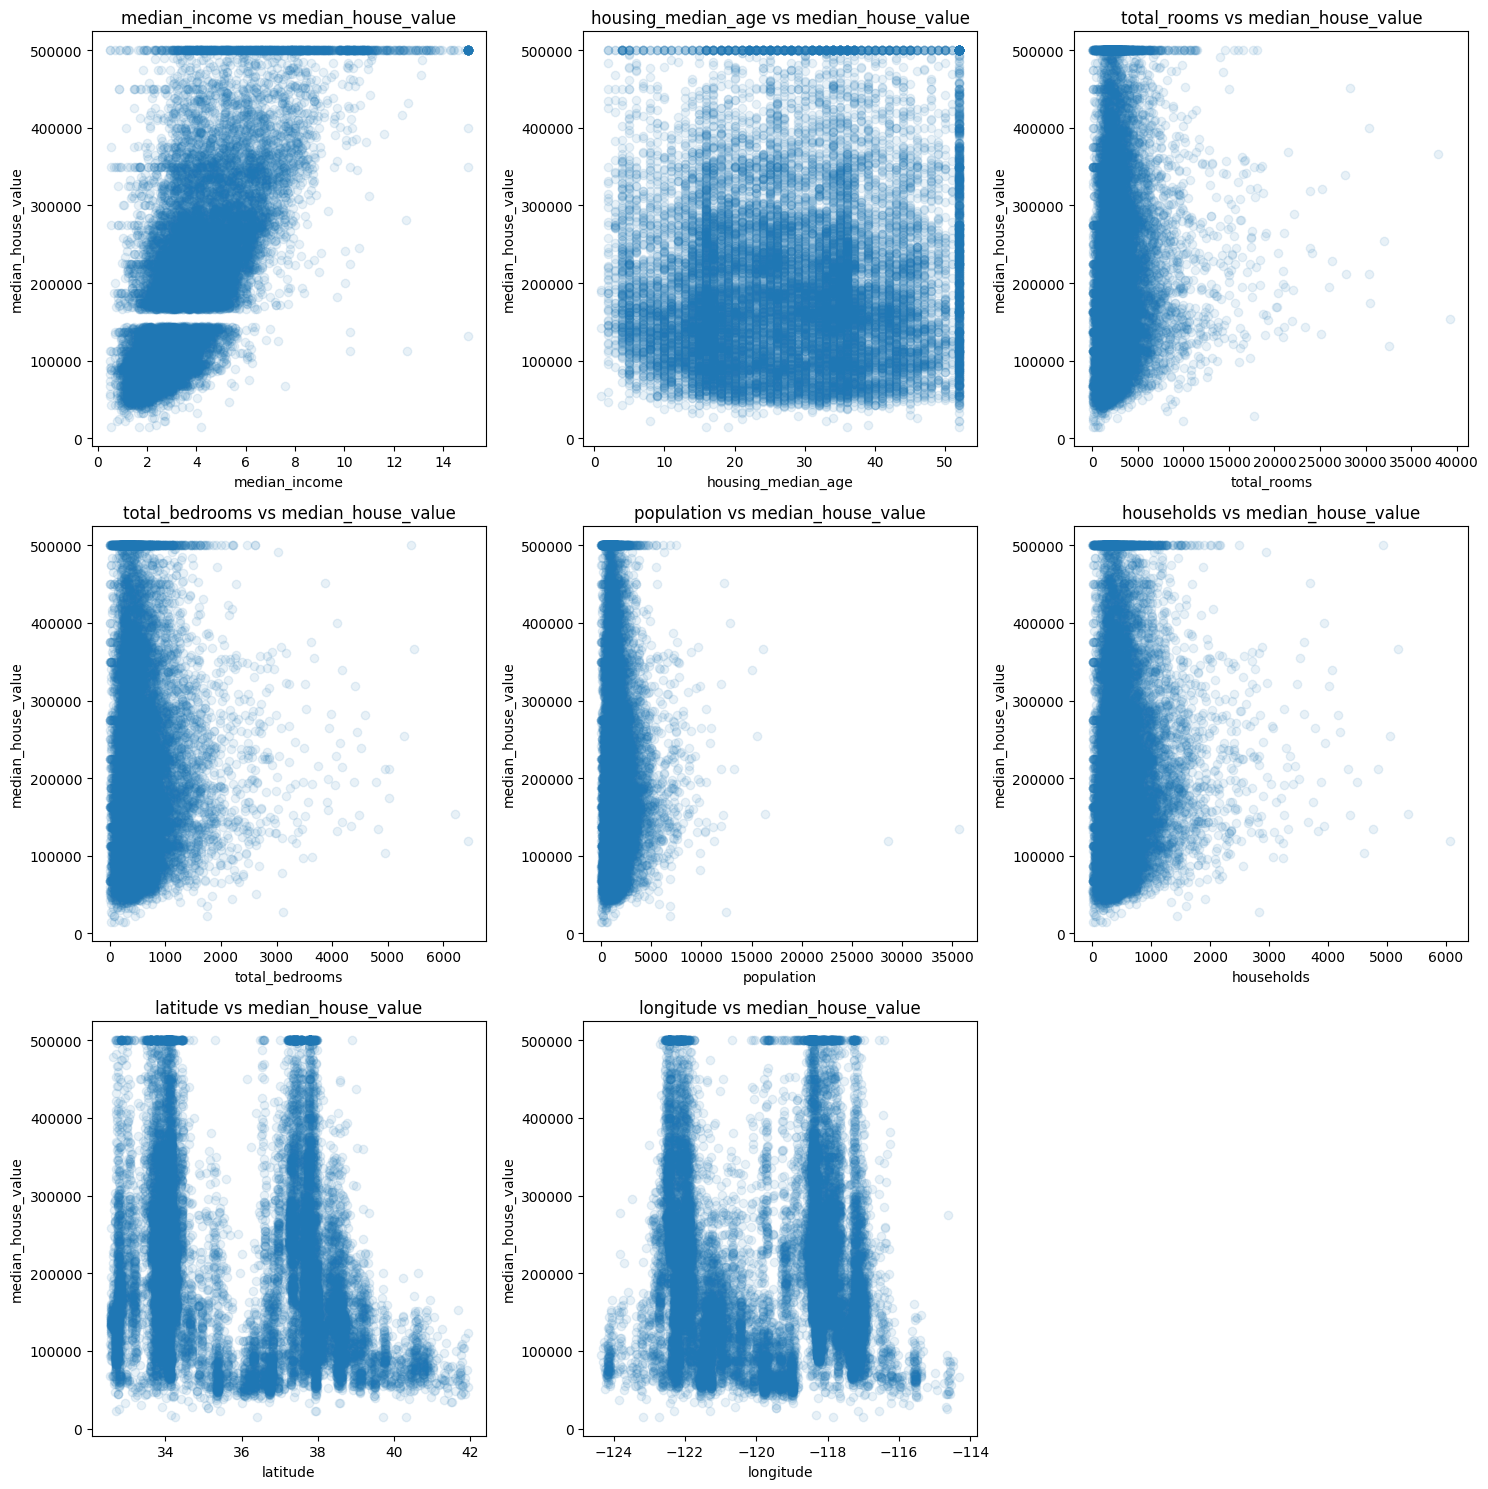

In [ ]:
X = houses_corrupted.drop(columns=['median_house_value'])
y = houses_corrupted['median_house_value']  # Target variable

# Select the columns to visualise
cols = X.columns.tolist()

# Determine the number of rows and columns for subplots
num_cols = len(cols)
num_rows = math.ceil(num_cols / 3)

# Create a plot for each column
fig, ax = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
ax = ax.ravel()

# Create scatter plots for each column
for i, col in enumerate(cols):
    ax[i].scatter(X[col], y, alpha=0.1)
    ax[i].set_title(f"{col} vs median_house_value")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("median_house_value")

for j in range(len(cols), len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

A key relationship to be observed is between `median_income` and `median_house_value`.

<Axes: xlabel='median_income', ylabel='median_house_value'>

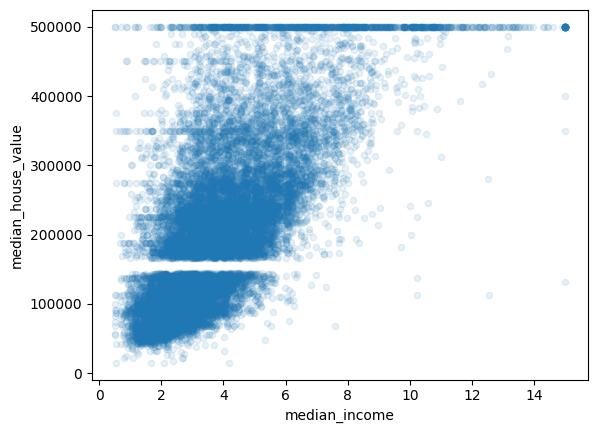

In [ ]:
houses_corrupted.plot(kind="scatter", x="median_income", y="median_house_value", alpha =0.1)

There appears to be missing data around the 150,000 mark for median_house_value, which could indicate gaps in the dataset. Additionally, the price cap at 500,000 is clearly visible, with a distinct dark line along the top. Another noticeable pattern is the clustering around 350,000. Overall, it's evident that there is a **strong correlation** between `median_income` and `median_house_value`, with both values increasing together.

####1.3.2 Geographic Patterns

There is also a strong negative correlation between `longitude` and `latitude`, further supporting the idea that these attributes represent geographic locations. This relationship can be visualised with a **scatter plot.**

<Axes: xlabel='latitude', ylabel='longitude'>

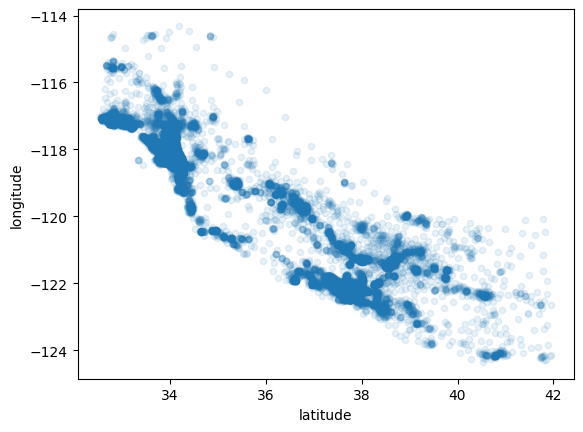

In [ ]:
houses_corrupted.plot(kind="scatter", x="latitude", y="longitude", alpha =0.1)

We can observe several areas of **high density** particularly on the left of the graph with the right being more sparsely populated. This suggests that the majority of households are **clustered** in these regions. Additionally, these high density areas are likely well-developed, offering better infrastructure and improved access to facilities, making them more popular places to live. This, in turn, may contribute to higher housing prices in these regions. To explore this further, we can plot the distribution of `median_house_values` on a scatter plot, using `longitude` and `latitude` as the x and y coordinates.

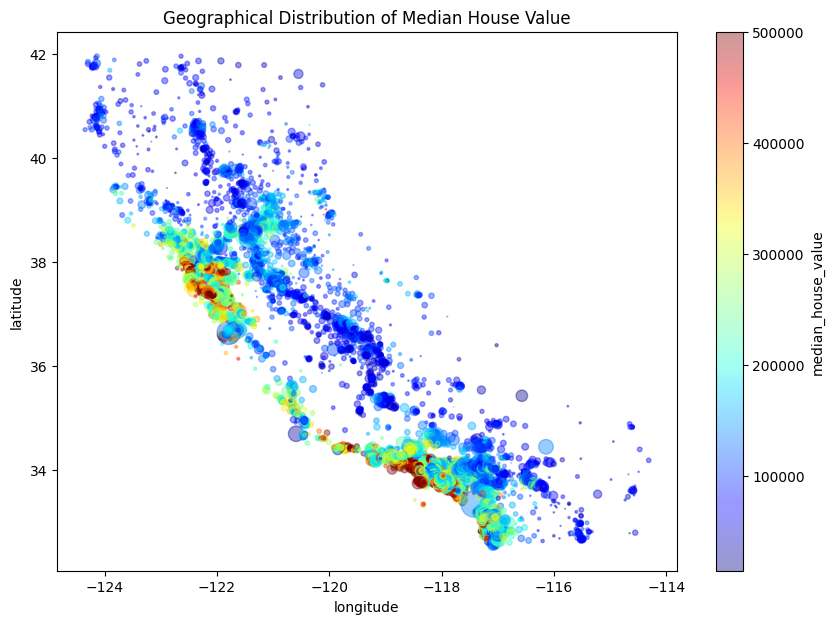

In [ ]:
# Scatter plot with the colour representing median_house_value
houses_corrupted.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    s=houses_corrupted["population"] / 100,
    figsize=(10, 7)
)

plt.title("Geographical Distribution of Median House Value")
plt.show()


The most expensive houses are located along the far-left edge of the data, while densely populated areas in the central regions exhibit much lower prices. This suggests that certain features or attractions in the leftmost area may be increasing house prices.

##2. Outlier Detection

**Outliers** are anomalies within a dataset that deviate significantly from other observations, raising the question of whether they were generated by a different mechanism. These outliers can corrupt a dataset when used for analysis or model training. Detecting outliers is important for maintaining **data integrity** and uncovering valuable insights into unusual behaviors within the dataset.

I have decided to detect outliers before performing imputation. Although some outlier detection methods require a complete dataset for effective detection, imputing missing values beforehand, especially using methods like KNN, could skew the results, as KNN is distance-based and may be influenced by outliers.

To address this, I will temporarily fill missing values with the **median** because the median is less likely to be distorted by skewed data. Additionally, I plan to exclude the `longitude` and `latitude` columns from the outlier detection process. Since these columns represent geographical locations rather than errors in the data, treating them as potential outliers is unnecessary.

In [ ]:
# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
houses_imputed = pd.DataFrame(imputer.fit_transform(houses_corrupted),
                              columns=houses_corrupted.columns)

# Drops the longitude and latitude columns
houses_dropped = houses_imputed.drop(columns=["longitude", "latitude"])

###2.1 Statistical Outlier detection

####2.1.1 Robust Z-Score

One approach to identifying outliers in a dataset is the **Robust Z-score** method, which improves upon the Z-score method by using the **median** and the **median absolute deviation (MAD)** instead of the mean and standard deviation. This makes it more resilient to skewed data and extreme outliers. By comparing the Robust Z-score to a fixed threshold, we can identify potential outliers more reliably.

In [ ]:
# Calculates the meand and standard deviation for all data points
means = houses_dropped.mean()
std = houses_dropped.std()

# Calculates the z-scores for each data point
z_scores = (houses_dropped - means) / std

# Checks z-scores if they are above the threshold
outliers = (z_scores.abs() > 3)

# Prints the number of outliers per column and total
print("\nNumber of Outliers per Column:")
print(outliers.sum())
print("\nTotal Number of Outliers in the Dataset:", outliers.sum().sum())


Number of Outliers per Column:
median_house_value      0
median_income         353
housing_median_age      0
total_rooms           373
total_bedrooms        371
population            345
households            363
dtype: int64

Total Number of Outliers in the Dataset: 1805


Here, we observe that a considerable proportion of the dataset contains extreme values. This is not unusual, given the variability in features such as population, income, and room counts, which can be influenced by factors like differences between urban and rural locations.

Although our **exploratory data analysis (EDA)** revealed potential outliers in the box plot for `median_house_value`, the **Robust Z-score** did not identify any. This difference is due to box plots relying on the **interquartile range (IQR)**, while the Robust Z-score uses the **median** and **MAD**. Additionally, the absence of outliers in `housing_median_age` suggests that variability in this feature is not extreme.

####2.1.2 Visualise Outliers

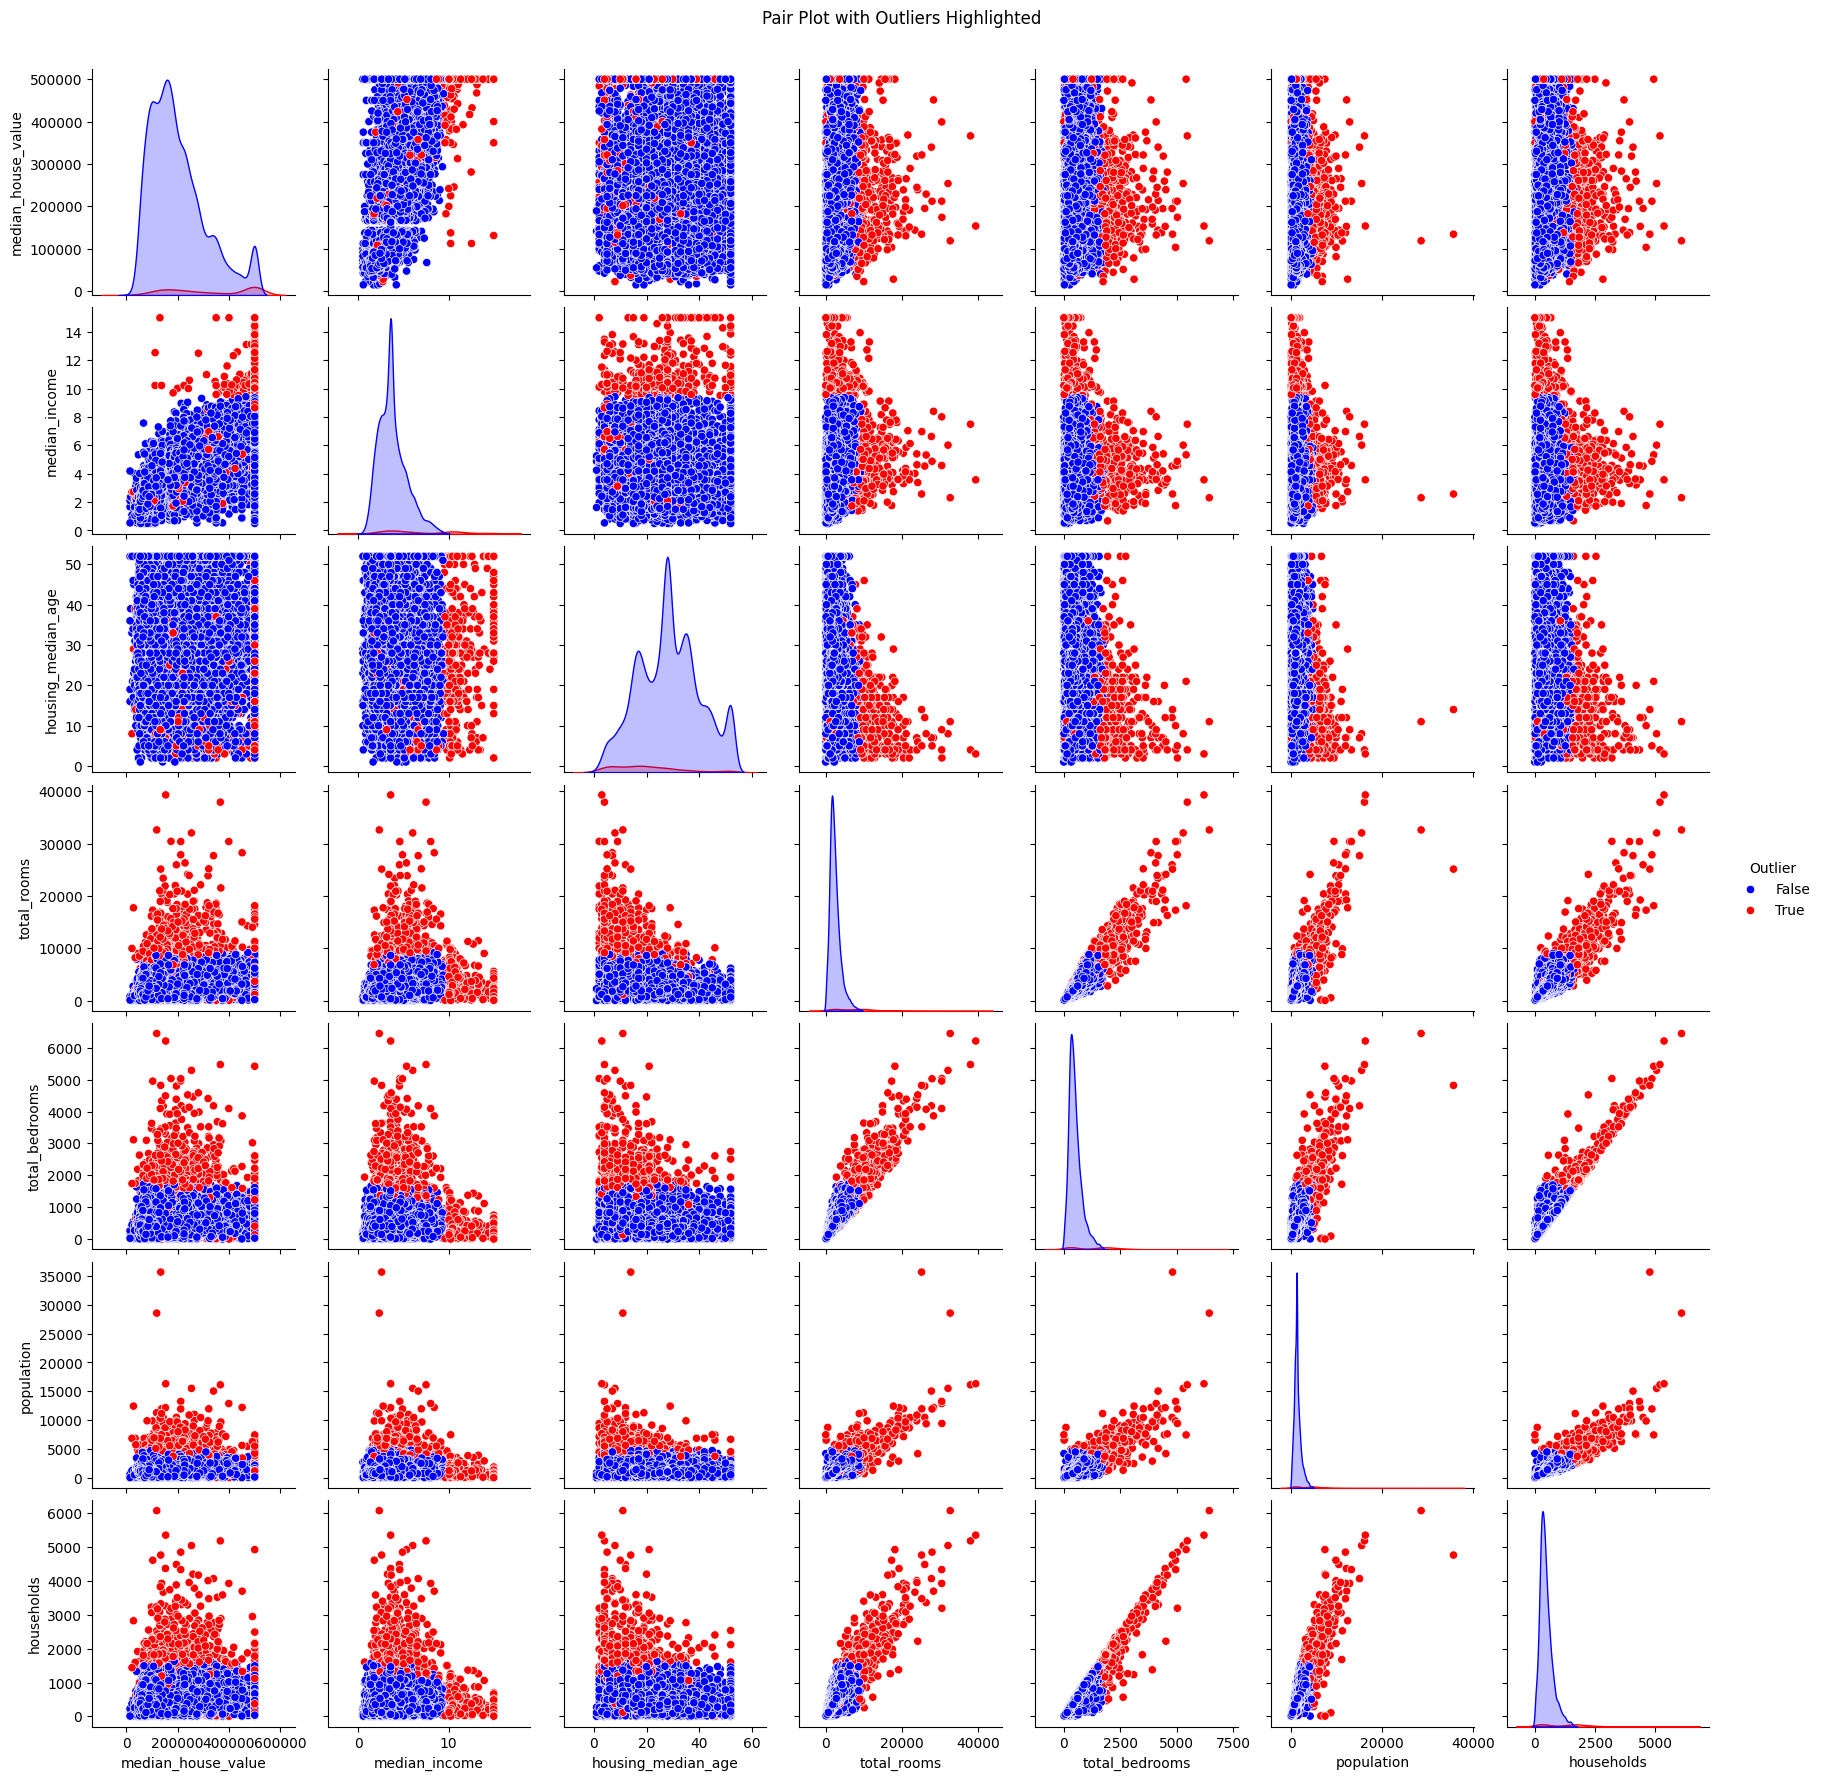

In [ ]:
# Create a copy of the data to add an outlier column
houses_dropped_with_outliers = houses_dropped.copy()
houses_dropped_with_outliers["Outlier"] = outliers.any(axis=1)  # Mark rows as outliers if any column is an outlier

# Create a pair plot to visualise outliers
sns.pairplot(houses_dropped_with_outliers, hue="Outlier", palette={True: "red", False: "blue"})
plt.suptitle("Pair Plot with Outliers Highlighted", y=1.02)
plt.show()

In the `pair plot`, we can visually identify outliers within the dataset, and the **Robust Z-score** has effectively detected many of them. However, a significant portion of data points has been flagged as outliers, particularly in features like `population` and `total_rooms`. This raises a potential concern, as some of these flagged points may not truly be outliers but rather meaningful data. While **statistical approaches** are easy to implement, they often assume that data follows a specific distribution and may not perform well with complex, skewed data like `houses_corrupted`.

An **algorithmic detection** approach may be more suitable in this case, as it does not rely on assumptions and is better equipped to handle complex relationships and skewed data.

###2.2 Algorithmic outlier detection

####2.2.1 Isolation Forest (IF)

The decision to use **Isolation Forest** for `houses_corrupted` is based on its **efficiency** in handling complex data. This method is an 'unsupervised, decision-tree-based' algorithm that operates by repeatedly splitting the data using randomly selected features and values, with outliers being isolated through fewer splits (*Peixeiro, 2023*).

However, a key limitation is that Isolation Forest requires a **contamination parameter**, which specifies the expected percentage of outliers in the data. Since this parameter is set in advance, it relies on an assumption that may not always be accurate, which could affect the validity of the outliers detected or missed. We can estimate this parameter by analysing the box plots from the previous **exploratory data analysis (EDA)** performed.

In [ ]:
# Initialise Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42) # Set contamination parameter

# Fit the model and predict outliers
outliers_if = isolation_forest.fit_predict(houses_dropped)

outliers_if = outliers_if == -1

# Count the number of outliers
num_outliers = outliers_if.sum()
print(f"Number of outliers detected: {num_outliers}")

Number of outliers detected: 1032


For **Isolation Forest**, I chose a contamination parameter of `0.05` due to the high variability and skewness of the dataset. This helped avoid flagging extreme values as outliers, which might be important and should not be removed. The model identified `1,032 outliers`, demonstrating that the chosen contamination rate effectively detected outliers without discarding too much useful data.

####2.2.2 Visualise Outliers

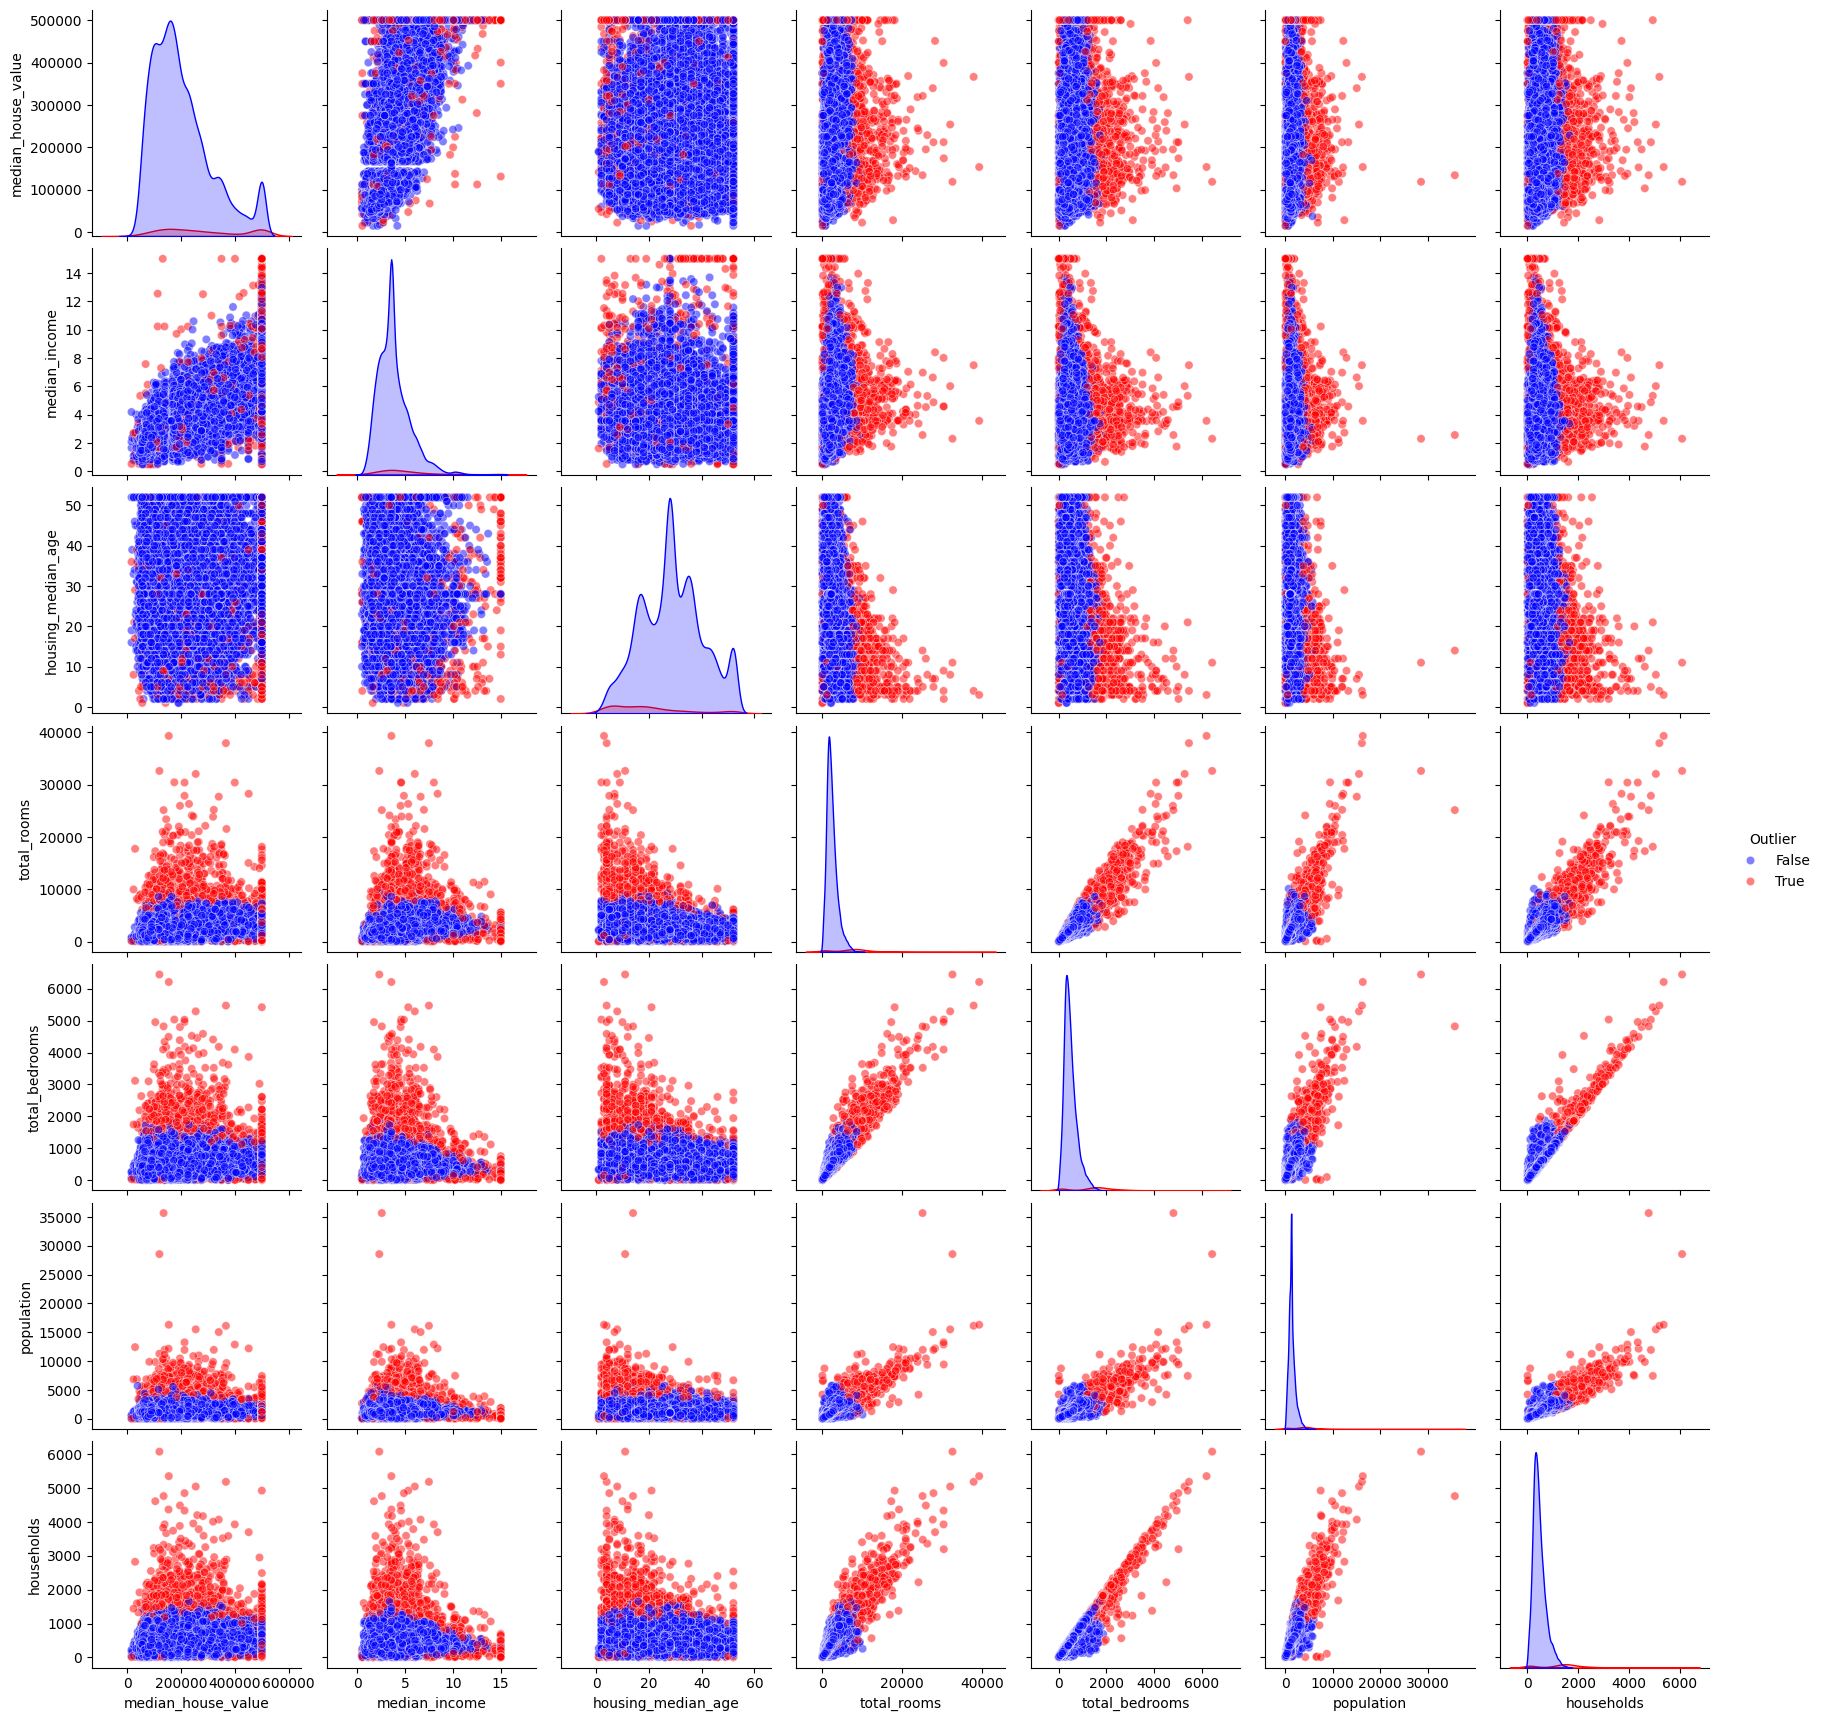

In [ ]:
# Create a copy of the data to add an outlier column
data_with_outliers = houses_dropped.copy()
data_with_outliers['Outlier'] = outliers_if # Mark rows as outliers if any column is an outlier

# Create a pair plot to visualise outliers
sns.pairplot(data_with_outliers, hue='Outlier', palette={True: "red", False: "blue"}, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

As seen again in the pair plot, Isolation Forest has been effective in identifying outliers, with distant points flagged in red.

####2.2.3 Comparison

The **Robust Z-score** is useful for simpler datasets but may struggle with complex, high-dimensional, or skewed data like `houses_corrupted`. While it is resistant to extreme values, it assumes a specific data distribution and can miss outliers in more intricate relationships. On the other hand, **Isolation Forest** is better suited for complex datasets, as it doesn't rely on distributional assumptions and can handle high variability and multi-dimensional features. Given the nature of the data, Isolation Forest is the more effective method for outlier detection moving forward.

When handling Outliers I will be utilising the outliers detected in Isolation Forest.

###2.3 Handling Outliers

For handling outliers, I have decided to remove them. The outliers detected represent only `0.05%` of the data, so their removal should not significantly impact the dataset. Additionally, the majority of the data is skewed, likely due to these extreme values, which could distort future modeling. By removing the outliers, this should help reduce the skew and bring the data closer to a more normal distribution.

In [ ]:
houses_corrupted_removed = houses_corrupted[~outliers_if]

print(f"Original dataset shape: {houses_corrupted.shape}")
print(f"Dataset shape after removing outliers: {houses_corrupted_removed.shape}")

Original dataset shape: (20640, 9)
Dataset shape after removing outliers: (19608, 9)


####2.3.1 Visualise Outlier removal

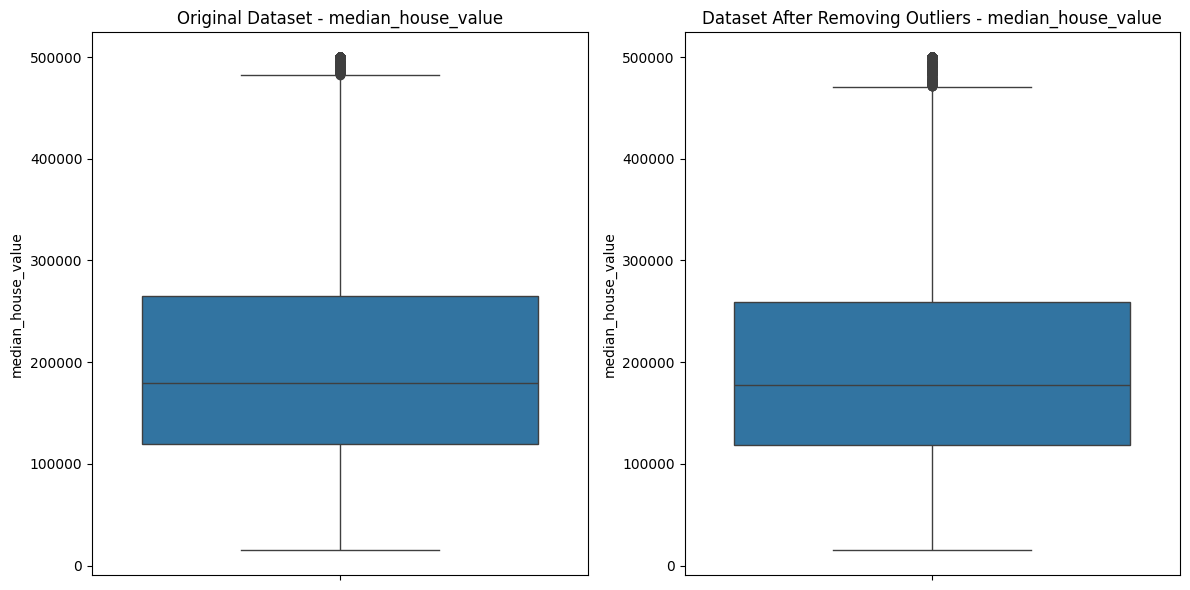

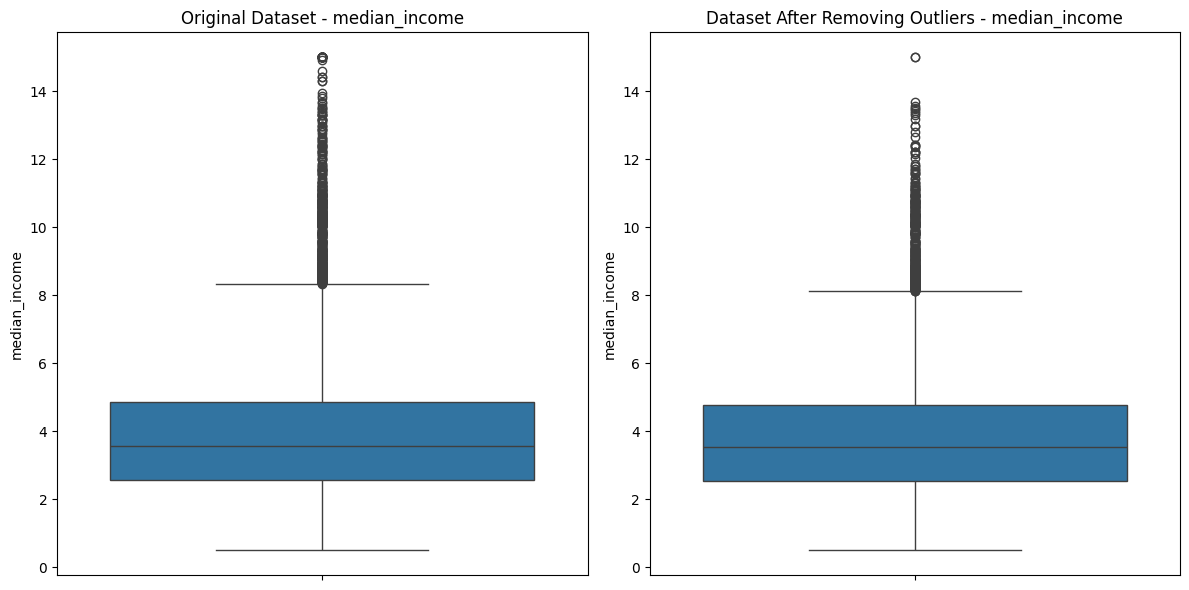

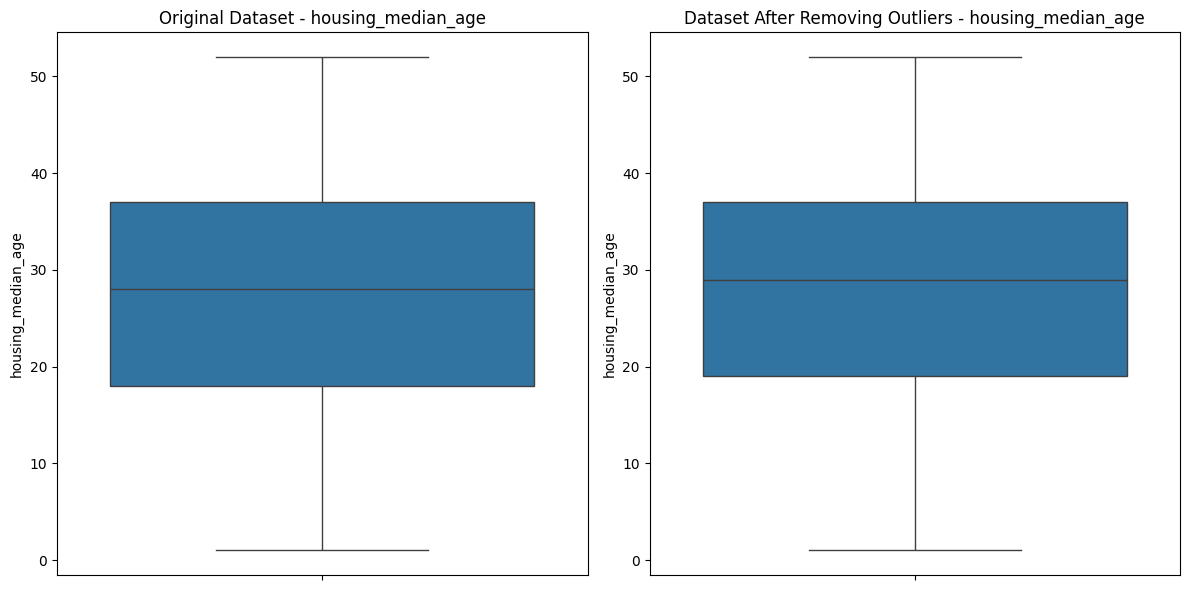

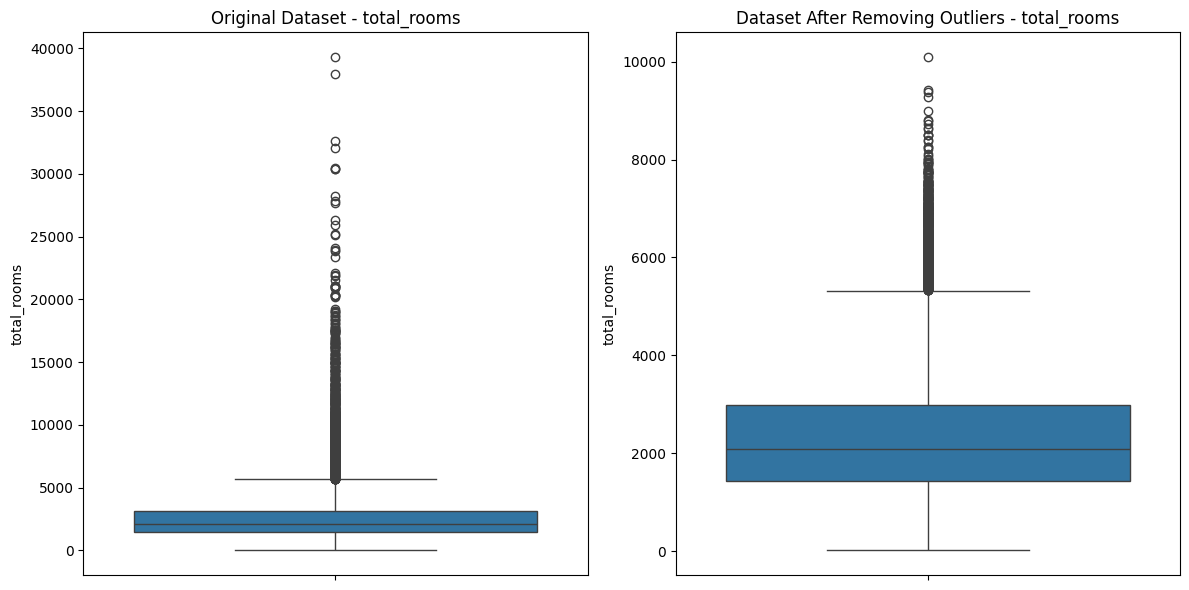

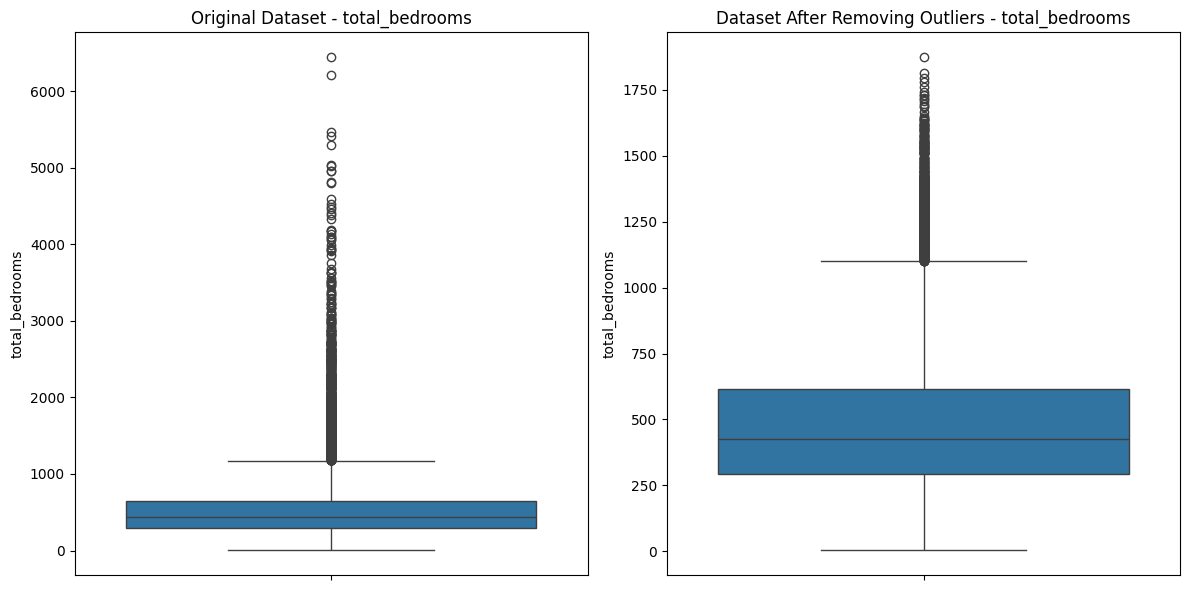

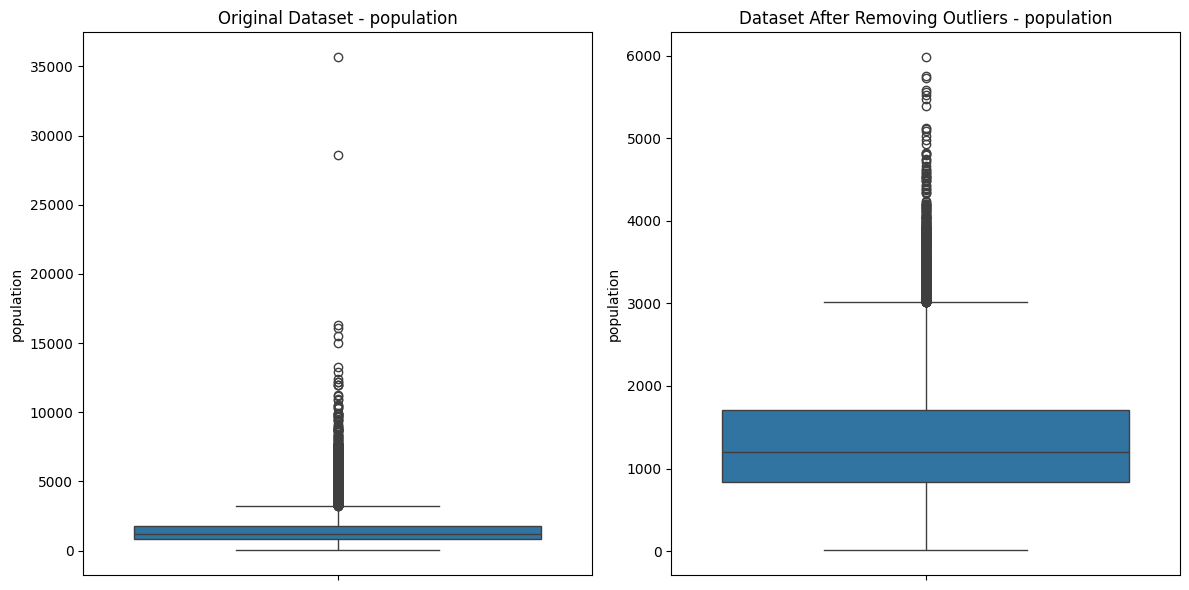

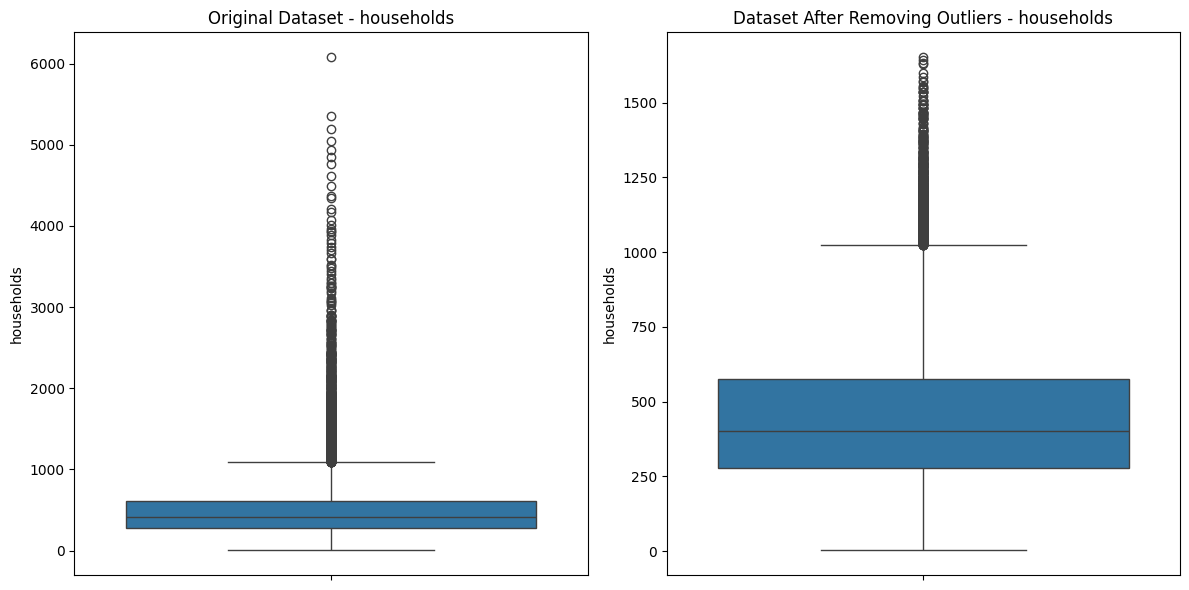

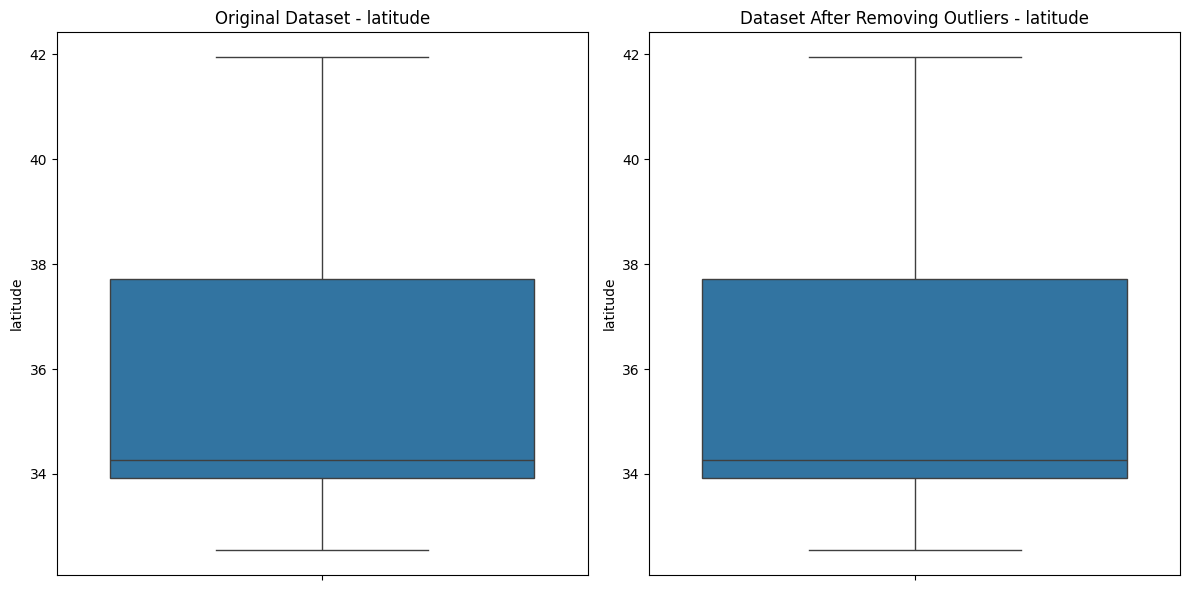

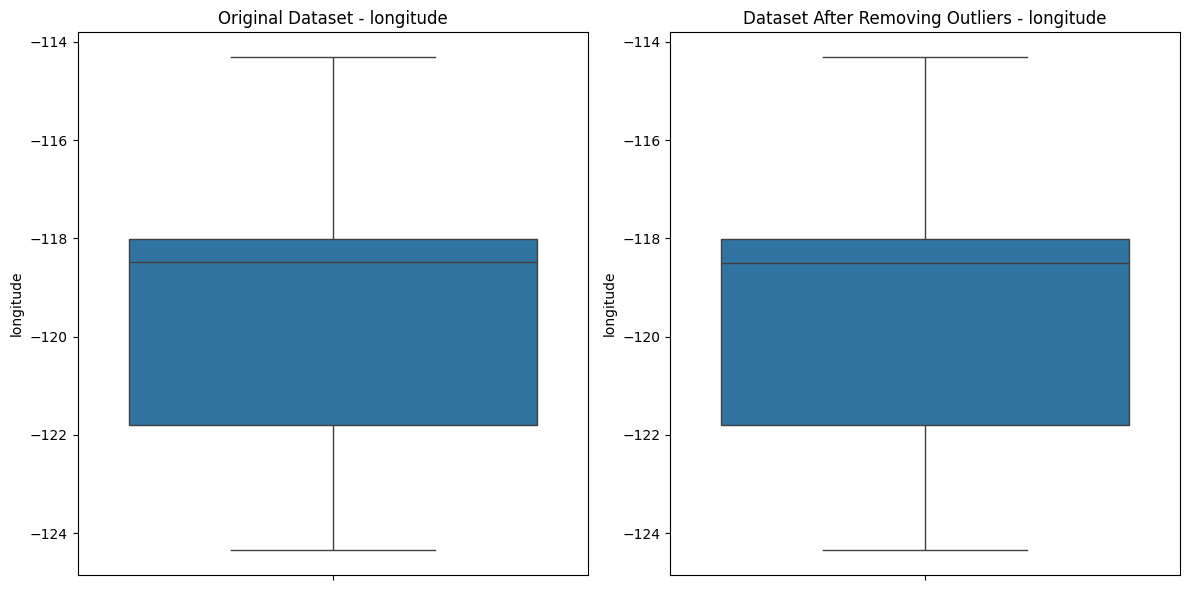

In [ ]:
# List of attributes
attributes = houses_corrupted.columns

# Create subplots for original and removed outlier columns
for attribute in attributes:
    plt.figure(figsize=(12, 6))

    # Boxplot for the original dataset
    plt.subplot(1, 2, 1)
    sns.boxplot(data=houses_corrupted, y=attribute)
    plt.title(f"Original Dataset - {attribute}")

    # Boxplot for the dataset after removing outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(data=houses_corrupted_removed, y=attribute)
    plt.title(f"Dataset After Removing Outliers - {attribute}")

    plt.tight_layout()
    plt.show()

Removing the outliers has helped spread out the data more evenly, especially in features like `population`, `total_rooms`, and `total_bedrooms`, where the lower part of the box plot has become wider. This is a good outcome because it makes the data better reflect its true range, without being distorted by extreme values. As a result, the dataset is more representative of the real patterns, which can improve the accuracy of future modeling.

###2.3.2 Statistical comparison

Original summary statistics

In [ ]:
houses_corrupted.describe()

median_house_value  median_income  housing_median_age   total_rooms  \
count        20640.000000   18576.000000        18576.000000  20640.000000   
mean        206855.816909       3.929958           28.324182   2635.763081   
std         115395.615874       1.964296           12.584914   2181.615252   
min          14999.000000       0.499900            1.000000      2.000000   
25%         119600.000000       2.560300           18.000000   1447.750000   
50%         179700.000000       3.572400           28.000000   2127.000000   
75%         264725.000000       4.870050           37.000000   3148.000000   
max         500001.000000      15.000100           52.000000  39320.000000   

       total_bedrooms    population    households      latitude     longitude  
count    20640.000000  18576.000000  20640.000000  20640.000000  20640.000000  
mean       537.898014   1488.069283    499.539680     35.631861   -119.569704  
std        421.247906   1170.585810    382.329753      2.135952      2.003532  
min          1.000000      3.000000      1.000000     32.540000   -124.350000  
25%        295.000000    839.000000    280.000000     33.930000   -121.800000  
50%        435.000000   1227.000000    409.000000     34.260000   -118.490000  
75%        647.000000   1803.000000    605.000000     37.710000   -118.010000  
max       6445.000000  35682.000000   6082.000000     41.950000   -114.310000

After Outlier removal summary statistics

In [ ]:
houses_corrupted_removed.describe()

median_house_value  median_income  housing_median_age   total_rooms  \
count        19608.000000   17608.000000        17547.000000  19608.000000   
mean        202879.755406       3.831132           28.830512   2354.676357   
std         111961.032684       1.773112           12.305243   1338.838271   
min          14999.000000       0.499900            1.000000     11.000000   
25%         118200.000000       2.544550           19.000000   1437.000000   
50%         177300.000000       3.535100           29.000000   2080.000000   
75%         259400.000000       4.775125           37.000000   2992.000000   
max         500001.000000      15.000100           52.000000  10098.000000   

       total_bedrooms    population    households      latitude     longitude  
count    19608.000000  17556.000000  19608.000000  19608.000000  19608.000000  
mean       484.736434   1342.212349    451.831650     35.651188   -119.587651  
std        272.765382    752.391365    249.748234      2.145052      2.001748  
min          3.000000      8.000000      2.000000     32.540000   -124.350000  
25%        294.000000    833.750000    278.000000     33.930000   -121.800000  
50%        426.000000   1199.000000    401.000000     34.270000   -118.510000  
75%        617.000000   1707.000000    576.000000     37.720000   -118.020000  
max       1875.000000   5982.000000   1653.000000     41.950000   -114.310000

The outlier removal process has reduced variability in the dataset, as seen in the lower standard deviations and means for most attributes, such as `total_rooms`, `total_bedrooms`, and `population`. Addtionally, extreme values, like the maximum value for `total_rooms`, which dropped from `39,320` to `10,098`, were addressed, leading to a less skewed dataset. Overall, it can be confirmed that 5% of the data has successfuly been removed by checking the counts of each column.

###3. Imputation

**Data imputation** refers to the handling of missing values in a dataset. There are many reasons for missing values within a dataset. Imputation involves filling in these missing data points with appropriate subsitiutions (*DeepAI, 2019*). This process is vital to data analysis with the majority of machine learning algorithms requiring a complete dataset.

###3.1 Inspect data

In [ ]:
houses_corrupted_removed.isnull().sum()

median_house_value       0
median_income         2000
housing_median_age    2061
total_rooms              0
total_bedrooms           0
population            2052
households               0
latitude                 0
longitude                0
dtype: int64

Before attempting imputation, we must first inspect which columns are missing data. As shown above and discovered in our EDA, `median_income`, `housing_median_age`, and `population` all have missing values. The number of outliers detected during our EDA was the same for each column. However, after removal, the number of outliers has decreased slightly.

####3.1.1 Missing data analysis

During the **EDA**, when plotting `median_house_value` against `median_income`, I noticed a gap in the scatterplot. This gap could indicate a concentration of missing data in `median_income` for certain ranges of `median_house_value`. We can verify this by counting the number of missing values that correspond to this specific range.

<Axes: xlabel='median_income', ylabel='median_house_value'>

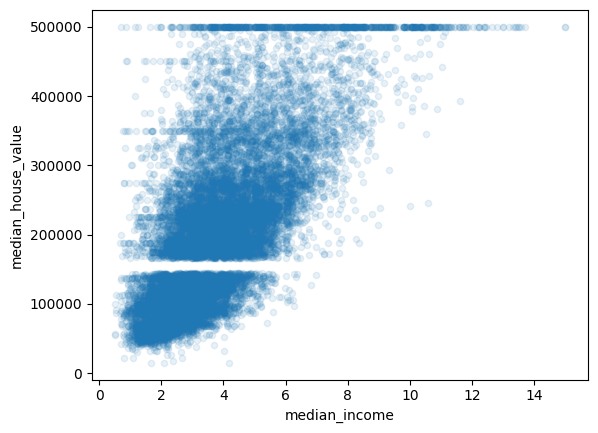

In [ ]:
houses_corrupted_removed.plot(kind="scatter", x="median_income", y="median_house_value", alpha =0.1)

In [ ]:
# Filter rows based on these conditions
specific_missing_data = houses_corrupted_removed[
    (houses_corrupted_removed['median_house_value'] > 130000) &
    (houses_corrupted_removed['median_house_value'] < 170000) &
    houses_corrupted_removed['median_income'].isnull()
]

# Count the number of rows that meet the conditions
specific_missing_data_count = specific_missing_data.shape[0]

print(f"Number of rows with missing 'median_income' and 'median_house_value' between 130,000 and 170,000: {specific_missing_data_count}")

Number of rows with missing 'median_income' and 'median_house_value' between 130,000 and 170,000: 2000


As we can see, all of the missing values in `median_income` correspond to `median_house_value` values between the range of **130,000 and 170,000**.

The missing data in `median_income` appears to follow a **Missing at Random (MAR)** pattern. This is because the missingness seems to be dependent on an observed variable, specifically `median_house_value`, rather than on the values of `median_income` itself.

The scatterplot also shows a strong correlation between the two features, as highlighted in the EDA, which will be important to consider during imputation to ensure accurate predictions for `median_income`.

We can check if a similar pattern of missingness exists for the `housing_median_age` and `population` columns.

<Axes: xlabel='population', ylabel='total_rooms'>

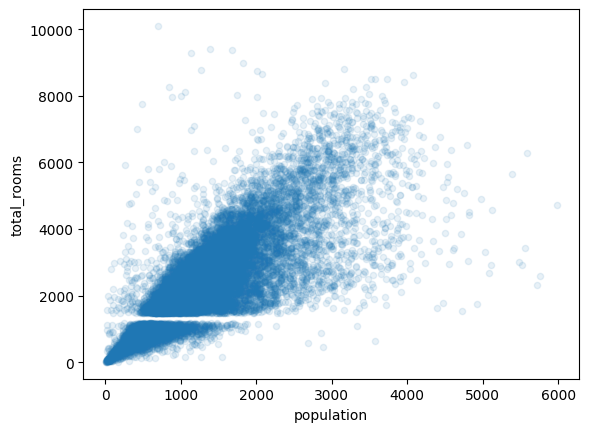

In [ ]:
houses_corrupted_removed.plot(kind="scatter", x="population", y="total_rooms", alpha =0.1)

In [ ]:
# Filter rows based on these conditions
specific_missing_data = houses_corrupted_removed[
    (houses_corrupted_removed['total_rooms'] > 1100) &
    (houses_corrupted_removed['total_rooms'] < 1500) &
    houses_corrupted_removed['population'].isnull()
]

# Count the number of rows that meet the conditions
specific_missing_data_count = specific_missing_data.shape[0]

print(f"Number of rows with missing 'population' and 'total_rooms' between 1,100 and 1,500: {specific_missing_data_count}")

Number of rows with missing 'population' and 'total_rooms' between 1,100 and 1,500: 2052


We can see that `population` exhibits the same pattern as `median_income` when plotted against `total_rooms`, with the missing values corresponding to `total_rooms` values concentrated between **1,100 and 1,500**.

<Axes: xlabel='housing_median_age', ylabel='population'>

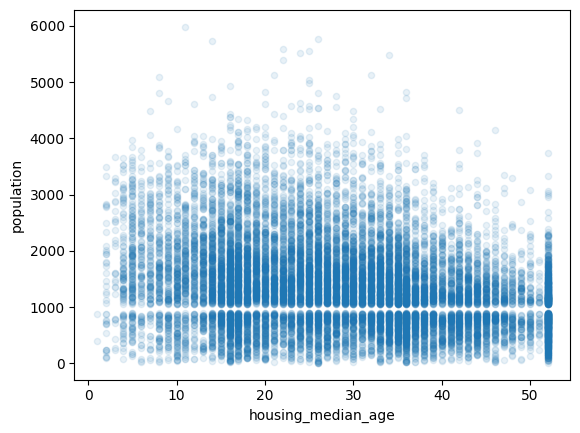

In [ ]:
houses_corrupted_removed.plot(kind="scatter", x="housing_median_age", y="population", alpha =0.1)

In [ ]:
# Filter rows based on these conditions
specific_missing_data = houses_corrupted_removed[
    (houses_corrupted_removed['population'] > 800) &
    (houses_corrupted_removed['population'] < 1100) &
    houses_corrupted_removed['housing_median_age'].isnull()
]

# Count the number of rows that meet the conditions
specific_missing_data_count = specific_missing_data.shape[0]

print(f"Number of rows with missing 'housing_median_age' and 'population' between 800 and 1,100: {specific_missing_data_count}")

Number of rows with missing 'housing_median_age' and 'population' between 800 and 1,100: 1856


When looking at `housing_median_age`, there were no significantly strong correlations with any other attributes, with the highest being a correlation of **-0.37** with `total_bedrooms`. However, I did find a similar gap when comparing `housing_median_age` against `population`, and upon further investigation, I found that the majority of missing values in `housing_median_age` corresponded to population values between **1,100 and 1,500**. However, not all missing values fall within this range, which suggests that the missingness in `housing_median_age` is not as strongly tied to other attributes in the dataset as it is with `median_income` and `population`.

####3.1.1 Rationale

Based on thess observation, we can determine which columns should be **imputed** and which should be removed. In this case, all three columns should be imputed. The primary reason for this decision is that none of the columns have more than 30% of their data missing, which is our threshold for deciding whether to impute or remove data. Each column has less than 10% of its data missing.

Furthermore, the identified columns appear to play a significant role in their relationships with other variables, as revealed during the correlation analysis in our initial **exploratory data analysis** (EDA). `median_income` is likely a significant predictor of housing prices, as income generally influences housing affordability. Similarly, `housing_median_age` can highlight trends in the values of older versus newer homes. Lastly, `population` provides important context for different areas, such as population density, which may impact housing prices.

###3.2 Impute missing values



####3.2.1 K-Nearest Neighbours (KNN)

Throughout the **EDA**, we discovered some moderately strong correlations between features, which we can use to help impute missing values. To take advantage of this, a **multivariate approach** like K-Nearest Neighbors (KNN) is a good choice.

KNN imputation utilises the **Euclidean distance** function to find similar data points and impute values based on their proximity to the missing data (*School, 2017*).

It is usually recommened to impute missing values before scaling, as scaling requires complete data and works best when there are no missing values to distort the process. However, for methods like KNN imputation, which rely on distance calculations, scaling before imputation may be more effective to prevent larger features from dominating the distance metric. For this reason, I will test both methods to determine the best approach.

######KNN without Scaling

In [ ]:
# Define the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust n_neighbors

# Perform imputation without scaling
houses_corrupted_imputed = pd.DataFrame(knn_imputer.fit_transform(houses_corrupted_removed), columns=houses_corrupted_removed.columns)

houses_corrupted_imputed.head()

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            352100.0         7.2574                52.0       1467.0   
2            341300.0         5.6431                52.0       1274.0   
3            342200.0         3.8462                52.0       1627.0   
4            269700.0         4.0368                52.0        919.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1           190.0       678.2       177.0     37.85    -122.24  
2           235.0       537.0       219.0     37.85    -122.25  
3           280.0       565.0       259.0     37.85    -122.25  
4           213.0       413.0       193.0     37.85    -122.25

We can verify that all missing values have been imputed by checking that the count of missing values is zero.

In [ ]:
houses_corrupted_imputed.isnull().sum()

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
dtype: int64

We will only look at `median_income`, `housing_median_age` and `population` as these are the columns missing values that have been imputed which may change their **summary statistics**.

In [ ]:
houses_corrupted_removed[['median_income', 'housing_median_age', 'population']].describe()

median_income  housing_median_age    population
count   17608.000000        17547.000000  17556.000000
mean        3.831132           28.830512   1342.212349
std         1.773112           12.305243    752.391365
min         0.499900            1.000000      8.000000
25%         2.544550           19.000000    833.750000
50%         3.535100           29.000000   1199.000000
75%         4.775125           37.000000   1707.000000
max        15.000100           52.000000   5982.000000

In [ ]:
houses_corrupted_imputed[['median_income', 'housing_median_age', 'population']].describe()

median_income  housing_median_age    population
count   19608.000000        19608.000000  19608.000000
mean        3.776011           29.140422   1292.375173
std         1.693628           11.838318    729.878606
min         0.499900            1.000000      8.000000
25%         2.630925           20.000000    804.000000
50%         3.445700           30.000000   1130.000000
75%         4.600000           37.000000   1634.250000
max        15.000100           52.000000   5982.000000

For the imputed columns, minor changes were observed in the summary statistics. For example, the **mean** of `median_income` decreased slightly, and the `standard deviation` of `population` reduced, reflecting a more concentrated distribution of values. These changes suggest that the imputation did not drastically alter the data but filled in missing values in a way that preserved the overall patterns of the dataset.

######KNN with Scaling

In [ ]:
# Scale the data
scaler = StandardScaler()
houses_corrupted_scaled = pd.DataFrame(scaler.fit_transform(houses_corrupted_removed), columns=houses_corrupted_removed.columns)

# Define the KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)
houses_corrupted_scaled_imputed = pd.DataFrame(knn_imputer.fit_transform(houses_corrupted_scaled), columns=houses_corrupted_removed.columns)

# Unscale the data for comparison
houses_corrupted_imputed_sc = pd.DataFrame(scaler.inverse_transform(houses_corrupted_scaled_imputed), columns=houses_corrupted_removed.columns)

houses_corrupted_imputed_sc.head()

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            352100.0         7.2574                52.0       1467.0   
2            341300.0         5.6431                52.0       1274.0   
3            342200.0         3.8462                52.0       1627.0   
4            269700.0         4.0368                52.0        919.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1           190.0       661.2       177.0     37.85    -122.24  
2           235.0       571.8       219.0     37.85    -122.25  
3           280.0       565.0       259.0     37.85    -122.25  
4           213.0       413.0       193.0     37.85    -122.25

In [ ]:
houses_corrupted_removed[['median_income', 'housing_median_age', 'population']].describe()

median_income  housing_median_age    population
count   17608.000000        17547.000000  17556.000000
mean        3.831132           28.830512   1342.212349
std         1.773112           12.305243    752.391365
min         0.499900            1.000000      8.000000
25%         2.544550           19.000000    833.750000
50%         3.535100           29.000000   1199.000000
75%         4.775125           37.000000   1707.000000
max        15.000100           52.000000   5982.000000

In [ ]:
houses_corrupted_imputed_sc[['median_income', 'housing_median_age', 'population']].describe()

median_income  housing_median_age    population
count   19608.000000        19608.000000  19608.000000
mean        3.781336           29.232385   1294.836200
std         1.702229           11.982953    729.889084
min         0.499900            1.000000      8.000000
25%         2.583300           19.000000    807.000000
50%         3.503900           30.000000   1135.000000
75%         4.625000           37.000000   1639.000000
max        15.000100           52.000000   5982.000000

Looking at the summary statistics KNN imputation with scaling appears to have slightly improved the dataset, particularly by reducing the variability in the imputed values. While the changes in **mean** and **standard deviation** are minimal, they suggest that scaling helped produce more consistent imputation results, especially for variables with larger numerical ranges, such as population. Therefore, KNN imputation with scaling is slightly better in terms of consistency and producing more balanced results compared to KNN imputation without scaling.

####3.2.2 Multivariate Imputation by Chained Equations

**Multivariate Imputation by Chained Equations (MICE)** is an advanced imputation technique that improves upon simpler methods by considering the relationships between multiple variables in the dataset. Since our data exhibits some strong correlations between attributes, such as between `median_house_value` and `median_income`, **MICE** is well-suited for this scenario, as it can use these relationships to better estimate missing values. Unlike **univariate** approaches, which impute missing values independently, MICE iterates through features, using existing data to estimate missing values based on their correlations with other variables.  By generating multiple imputed values, MICE also accounts for the uncertainty in missing data, leading to more reliable and accurate results.

In [ ]:
houses_MICE = houses_corrupted_removed

# Implement Random Forest Regressor
rf_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=100),
                              random_state=100,
                              max_iter=20)

# Fit the imputer
rf_imputer.fit(houses_MICE)

# Transform the data
houses_MICE_imputed = pd.DataFrame(rf_imputer.transform(houses_MICE), columns=houses_MICE.columns)

houses_MICE_imputed.head()

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            352100.0         7.2574                52.0       1467.0   
2            341300.0         5.6431                52.0       1274.0   
3            342200.0         3.8462                52.0       1627.0   
4            269700.0         4.0368                52.0        919.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1           190.0       533.8       177.0     37.85    -122.24  
2           235.0       585.4       219.0     37.85    -122.25  
3           280.0       565.0       259.0     37.85    -122.25  
4           213.0       413.0       193.0     37.85    -122.25

In [ ]:
houses_MICE_imputed.isnull().sum()

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
dtype: int64

In [ ]:
houses_MICE_imputed[['median_income', 'housing_median_age', 'population']].describe()

median_income  housing_median_age    population
count   19608.000000        19608.000000  19608.000000
mean        3.789896           29.101902   1292.268645
std         1.701706           12.038233    732.568429
min         0.499900            1.000000      8.000000
25%         2.586545           19.000000    789.000000
50%         3.515600           29.000000   1141.000000
75%         4.639400           37.000000   1639.000000
max        15.000100           52.000000   5982.000000

After applying **MICE** to the dataset, we observed that the imputation process successfully restored the missing values, bringing the count for all features to their full dataset size. While there were slight changes in the mean, standard deviation, and percentiles, these adjustments were minimal, indicating that the imputed values closely aligned with the overall distribution of the data. The imputation did not introduce any extreme outliers, and the key characteristics of the dataset, such as the min and max values, remained unchanged. Overall, MICE effectively filled in the missing data without significantly distorting the underlying structure.

###3.3 Comparison

####3.3.1 Original dataset Handling

In [ ]:
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

To ensure a fair comparison between the **original** and **imputed datasets**, I am removing the same outliers from the original dataset. This will maintain consistency, as outliers can skew results and distort patterns. Removing them also allows for a more accurate comparison of the imputation methods with the original by ensuring the datasets are treated similarly, enabling effective evaluation without the influence of extreme values.

In [ ]:
houses_removed = houses[~outliers_if]

# Check the result
print(f"Original dataset shape: {houses_corrupted.shape}")
print(f"Dataset shape after removing outliers: {houses_corrupted_removed.shape}")

Original dataset shape: (20640, 9)
Dataset shape after removing outliers: (19608, 9)


In [ ]:
houses.isnull().sum()

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
dtype: int64

We can also see that the original dataset has no missing values, making it an important comparison point for our imputed datasets to evaluate how well the missing values have been imputed.

####3.3.2 Summary Statistics

Summary Statistics for KNN imputation

In [ ]:
houses_corrupted_imputed_sc[['median_income', 'housing_median_age', 'population']].describe()

median_income  housing_median_age    population
count   19608.000000        19608.000000  19608.000000
mean        3.781336           29.232385   1294.836200
std         1.702229           11.982953    729.889084
min         0.499900            1.000000      8.000000
25%         2.583300           19.000000    807.000000
50%         3.503900           30.000000   1135.000000
75%         4.625000           37.000000   1639.000000
max        15.000100           52.000000   5982.000000

Summary Statistics for MICE imputation

In [ ]:
houses_MICE_imputed[['median_income', 'housing_median_age', 'population']].describe()

median_income  housing_median_age    population
count   19608.000000        19608.000000  19608.000000
mean        3.789896           29.101902   1292.268645
std         1.701706           12.038233    732.568429
min         0.499900            1.000000      8.000000
25%         2.586545           19.000000    789.000000
50%         3.515600           29.000000   1141.000000
75%         4.639400           37.000000   1639.000000
max        15.000100           52.000000   5982.000000

Both **MICE** and **KNN** imputation methods performed similarly in filling missing values for `median_income`, `housing_median_age`, and `population`, with the count for all columns reaching **19,608**. The means for the imputed datasets were close to the original, with MICE at **3.79** and KNN at **3.78**, compared to the original mean of **3.83**. Standard deviations and percentiles were nearly identical to the original dataset, indicating that neither method significantly altered the data's distribution.

Summary Statistics for original housing dataset

In [ ]:
houses_removed[['median_income', 'housing_median_age', 'population']].describe()

median_income  housing_median_age    population
count   19608.000000        19608.000000  19608.000000
mean        3.779726           29.108425   1292.161516
std         1.718709           12.322922    736.784720
min         0.499900            1.000000      8.000000
25%         2.551550           19.000000    782.000000
50%         3.505300           29.000000   1144.000000
75%         4.672075           37.000000   1647.000000
max        15.000100           52.000000   5982.000000

####3.3.3 Visual comparison

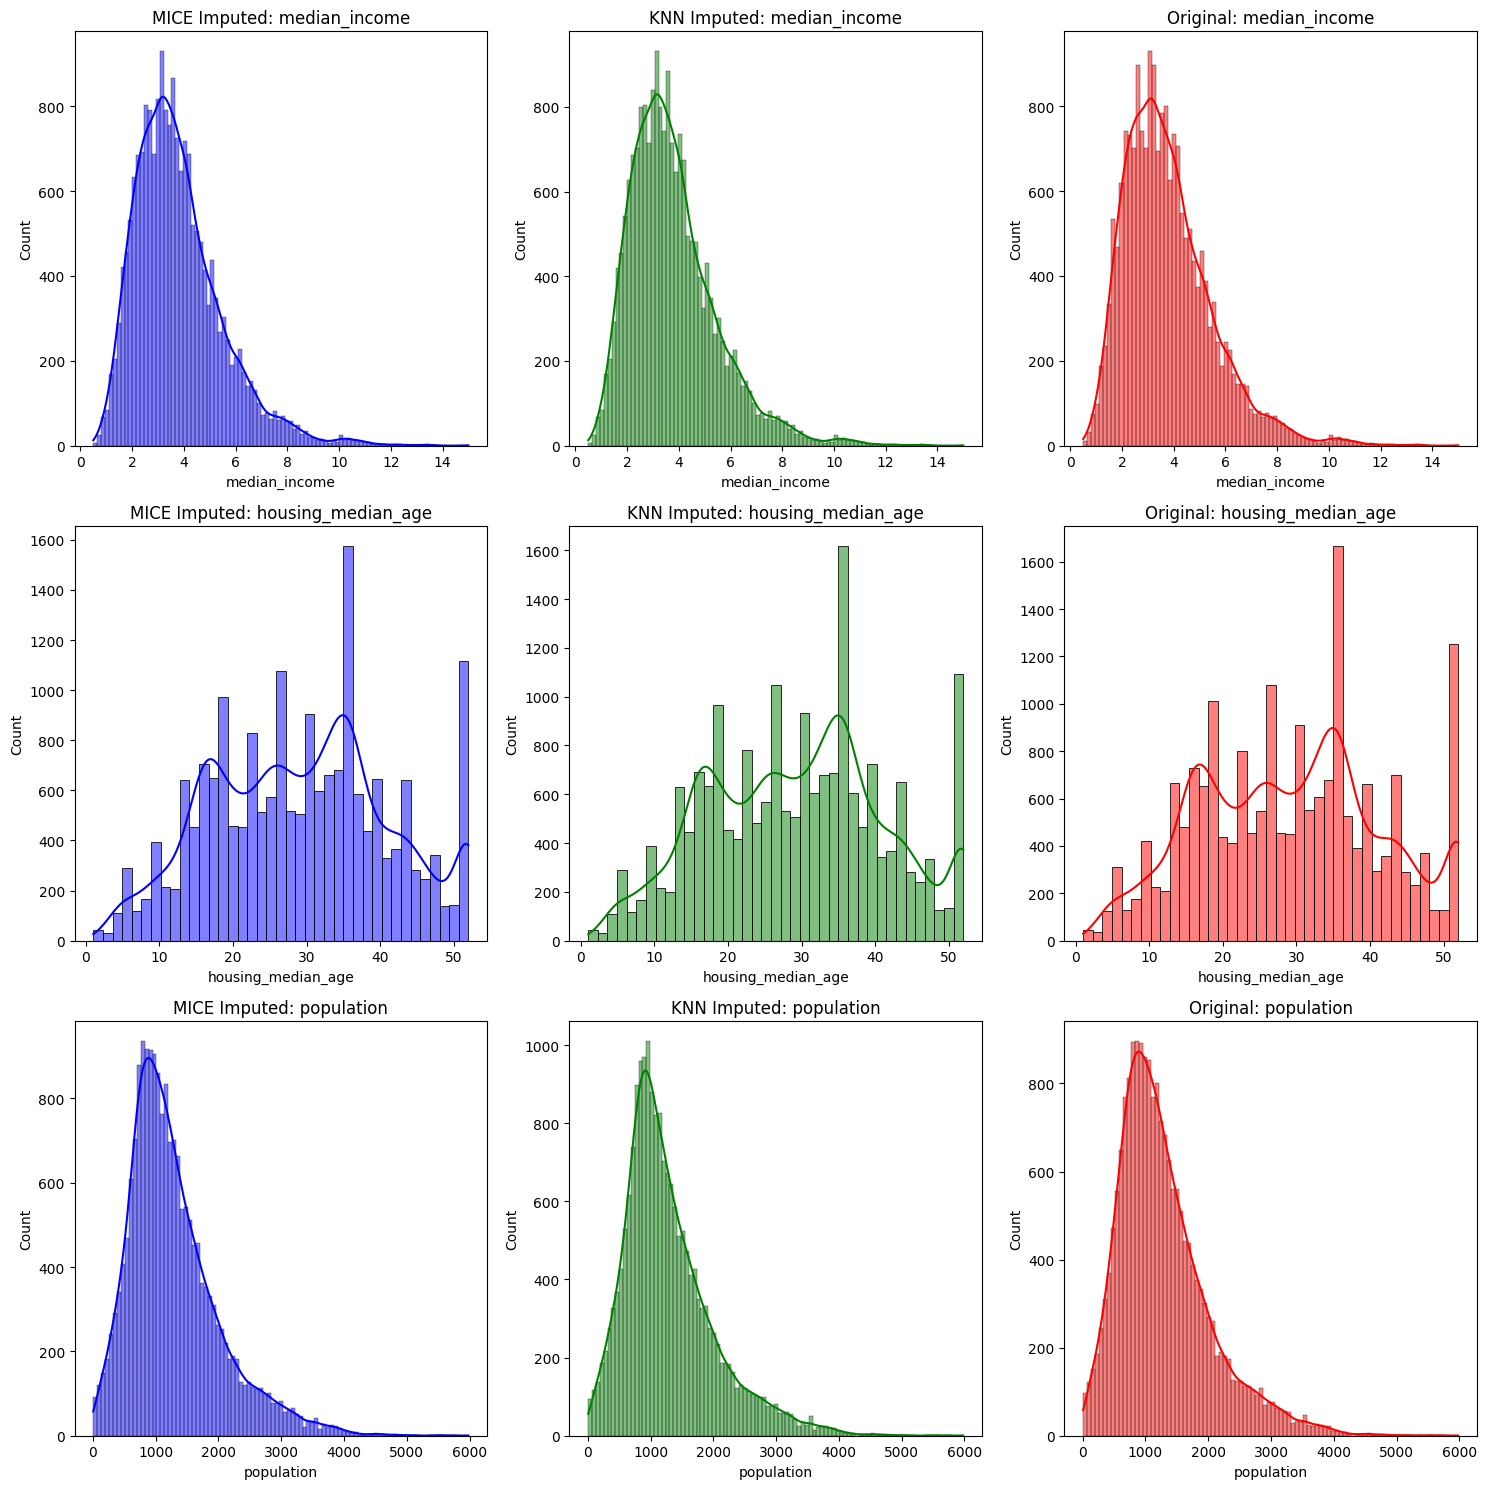

In [ ]:
# List of columns to compare
columns = ['median_income', 'housing_median_age', 'population']

fig, axes = plt.subplots(len(columns), 3, figsize=(15, 5*len(columns)))

for i, column in enumerate(columns):
    # Plot for MICE imputed data
    sns.histplot(houses_MICE_imputed[column], kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'MICE Imputed: {column}')

    # Plot for KNN imputed data
    sns.histplot(houses_corrupted_imputed_sc[column], kde=True, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'KNN Imputed: {column}')

    # Plot for Original data
    sns.histplot(houses_removed[column], kde=True, ax=axes[i, 2], color='red')
    axes[i, 2].set_title(f'Original: {column}')

plt.tight_layout()
plt.show()

Plotting the **histograms** for the three imputed columns reveals that all have a very similar shape, indicating that the imputation methods (KNN and MICE) did not introduce any extreme or unusual outliers, as observed visually.

###3.4 Regression models

Regression models are a machine learning technique used to identify and **quantify** the relationship between a dependent variable, known as a target, and one or more independent variables, known as predictors.

####3.4.1 Preparing the Dataset

An important step to take before regression is **scaling**, since my data includes features with significantly different scales. Features like `population` and `median_house_value` have much larger values compared to others, such as `housing_median_age`. Without scaling, features with larger values could dominate the regression model, leading to biased predictions. By standardising the data, all features are brought to a similar scale, allowing the model to learn from them in a balanced way. This step improves the model's accuracy and performance, ensuring that the regressor can effectively handle all features.

In [ ]:
# Step 4: Scale numeric columns (including log-transformed 'housing_median_age')
columns = houses_corrupted.columns

scaler = StandardScaler()

# Apply scaling using .loc to avoid SettingWithCopyWarning
houses_corrupted.loc[:, columns] = scaler.fit_transform(houses_corrupted[columns])
houses_removed.loc[:, columns] = scaler.transform(houses_removed[columns])
houses_MICE_imputed.loc[:, columns] = scaler.transform(houses_MICE_imputed[columns])
houses_corrupted_imputed_sc.loc[:, columns] = scaler.transform(houses_corrupted_imputed_sc[columns])

<ipython-input-49-5ec15b904414>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses_removed.loc[:, columns] = scaler.transform(houses_removed[columns])


###3.4.2 Build Regressor

For a regressor, I chose **Random Forest regression** as it is well-suited to the `houses_corrupted` dataset. The model can handle complex patterns and relationships in the data, and it effectively manages **skewed distributions** and **capped values**, such as those in the `median_house_value` and `housing_median_age` columns. Although outliers have been removed, the dataset still contains some extreme values, which the model accommodates. Additionally, Random Forest tends to generalise well, reducing the risk of overfitting and providing reliable predictions on new data.

In [ ]:
# Define the X and Y columns
X_columns = ['median_income', 'total_rooms', 'total_bedrooms', 'households', 'population',
             'housing_median_age', 'longitude', 'latitude']
y_column = 'median_house_value'

In [ ]:
# Function to evaluate the regression model
def evaluate_model(data, model, features, target):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mae, mse, r2

In [ ]:
# Initialise Random Forest model
rf_model = RandomForestRegressor(random_state=42)

In [ ]:
# Evaluate model on different datasets
mae_removed, mse_removed, r2_removed = evaluate_model(houses_removed, rf_model, X_columns, y_column)
mae_mice, mse_mice, r2_mice = evaluate_model(houses_MICE_imputed, rf_model, X_columns, y_column)
mae_knn, mse_knn, r2_knn = evaluate_model(houses_corrupted_imputed_sc, rf_model, X_columns, y_column)

To evaluate the model I am calculating the **Mean Absolute Error(MAE)**, the **Mean Squared Error(MSE)** and *R^2*.

*   **MAE** measures the average error between predictions and actual values in the same units
*   **MSE** highlights larger errors by penalising them more heavily, making it usefule for detecting significant deviations.
*   **R^2** complements these measures by showing how well the model explains the variability in the target variable, providing a normalised score for comparisons

These three measures offer insights into the model's accuracy, sensitivity to outliers, and ability to explain the data, enabling a comparison between the imputed and original datasets.

In [ ]:
# Print evaluation metrics
print(f"Original Data (Houses Removed) - MAE: {mae_removed}, MSE: {mse_removed}, R2: {r2_removed}")
print(f"MICE Imputed Data - MAE: {mae_mice}, MSE: {mse_mice}, R2: {r2_mice}")
print(f"KNN Imputed Data - MAE: {mae_knn}, MSE: {mse_knn}, R2: {r2_knn}")

Original Data (Houses Removed) - MAE: 0.262220317747303, MSE: 0.15611987180851808, R2: 0.8357176618370592
MICE Imputed Data - MAE: 0.2601655065543784, MSE: 0.1590355332883494, R2: 0.8326495598738076
KNN Imputed Data - MAE: 0.2650743365925429, MSE: 0.16095323420033206, R2: 0.8306315951773972


The results indicate that the performance of the **Random Forest regression model** is relatively consistent across the different datasets, with only slight variations. The original dataset performed best, achieving the lowest **Mean Absolute Error (MAE)** and **Mean Squared Error (MSE)**, and the highest **R^2**, which is expected as this dataset contains the complete orginial values. The **MICE** imputed dataset performed nearly as well, with comparable MAE and MSE, though its R^2 was slightly lower, indicating that it is a suitable alternative when preserving data is important. The **KNN** imputed dataset had the highest errors and the lowest R^2, suggesting that this method of imputation was slightly less effective for this dataset.

####3.4.1 Evaluate

To evaluate the performance of the regressor, we can visualise the **predicted** values against the **actual** values for each dataset. This approach allows to identify patterns in the model's predictions and assess its accuracy. By applying this analysis to the imputed datasets, we can compare the results to determine the most effective imputation approach.

In [ ]:
# Function for plotting predicted vs actual values
def plot_predictions(y_test, y_pred, title):
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.show()

In [ ]:
# Get the test set for each dataset
X_train_removed, X_test_removed, y_train_removed, y_test_removed = train_test_split(houses_removed[X_columns], houses_removed[y_column], test_size=0.2, random_state=42)
X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(houses_MICE_imputed[X_columns], houses_MICE_imputed[y_column], test_size=0.2, random_state=42)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(houses_corrupted_imputed_sc[X_columns], houses_corrupted_imputed_sc[y_column], test_size=0.2, random_state=42)

In [ ]:
# Train the model on each dataset
rf_model.fit(X_train_removed, y_train_removed)
y_pred_removed = rf_model.predict(X_test_removed)

rf_model.fit(X_train_mice, y_train_mice)
y_pred_mice = rf_model.predict(X_test_mice)

rf_model.fit(X_train_knn, y_train_knn)
y_pred_knn = rf_model.predict(X_test_knn)

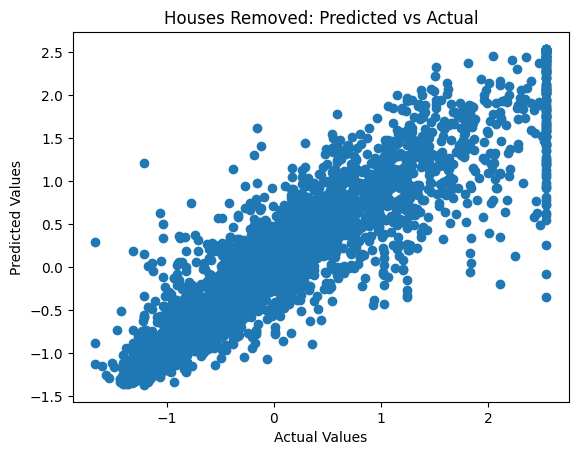

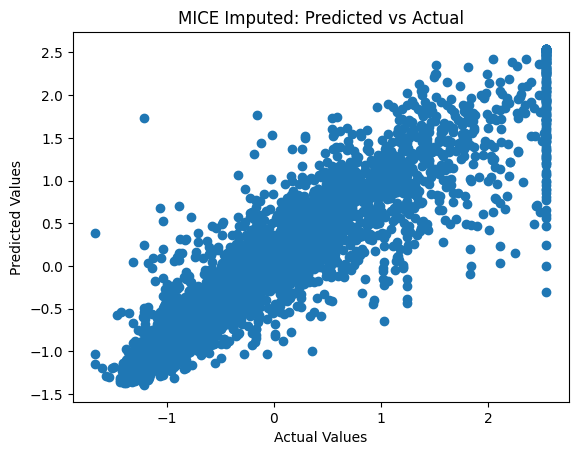

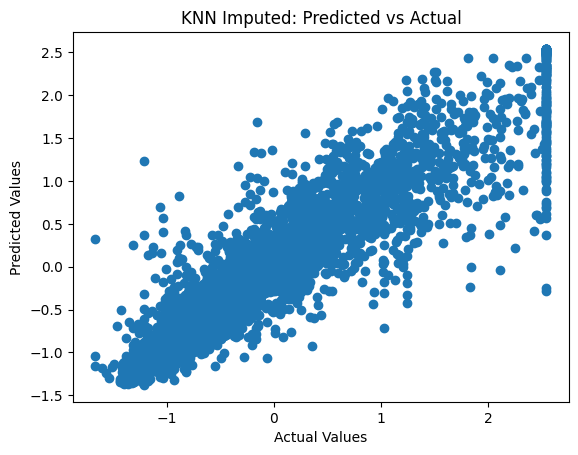

In [ ]:
# Plot predictions vs actual values for each dataset
plot_predictions(y_test_removed, y_pred_removed, "Houses Removed: Predicted vs Actual")
plot_predictions(y_test_mice, y_pred_mice, "MICE Imputed: Predicted vs Actual")
plot_predictions(y_test_knn, y_pred_knn, "KNN Imputed: Predicted vs Actual")

As seen in the plots, all three datasets have the majority of points clustered around the diagonal line with a mostly even distribution. This indicates that the model's **predictions** closely align with the **actual** values, reflecting accurate performance. Additionally, the even distribution suggests the model does not favor overpredicting or underpredicting, resulting in balanced and reliable predictions. While all datasets exhibit a fairly limited spread, the **KNN imputed** dataset has slightly more outliers compared to the **MICE imputed** and **original** datasets. This indicates that the model's predictions for the KNN dataset are somewhat less accurate.

##3. Conclusion and Thoughts

###1. Methods Used for Anomaly Detection, Pros, and Cons

In this coursework, anomaly detection was implemented using two approaches: **Robust Z-score**, a statistical method, and **Isolation Forest**, an algorithmic method.

The advantages of Robust z-score included being simple to implement and easily interpretable. However, this approach is sensitive to distributional assumptions, particularly the assumption of normality in the data. Since the `houses_corrupted` dataset does not follow a normal distribution, this sensitivity may cause the method to incorrectly flag extreme values as outliers that are important to the data.

In contrast, Isolation Forest does not rely on a predefined data distribution, making it more reliable for detecting outliers in this dataset. Additionally, it is well suited for high-dimensional datasets, such as `houses_corrupted` with its **9 attributes**, because it avoids the use of distance metrics that often degrade in higher dimensions. However, Isolation Forest requires a contamination parameter, which specifies the proportion of outliers in the dataset. This parameter relies on prior knowledge, and incorrect assumptions can lead to misclassification of normal data points as outliers.

I found Isolation Forest to be the better approach overall. For this reason, I chose to address the outliers it detected over those identified by Robust Z-score.

###2. Challenges and Difficulties in Anomaly Detection Implementation

Several challenges arose during anomaly detection. Firstly, it was important to use methods suitable for my data. I initially used **Z-score** as a statistical anomaly detection approach. However, this flagged a substantial number of outliers that did not align with visual inspection of the data. To address this, I switched to **Robust Z-score**, which is less influenced by skew as it uses the **median** and **MAD**. This adjustment significantly reduced the number of outliers flagged.

Another challenge was selecting an appropriate contamination parameter for **Isolation Forest**. To address this, I drew conclusions from the **EDA** and the number of anomalies detected by **Robust Z-score** to determine a suitable contamination parameter.


###3.3 Methods Used for Imputation, Pros, and Cons

The methods used for imputation included **Simple Statistical Imputer (median)**, **K-Nearest Neighbour (KNN)**, and **MICE (Iterative Imputer)**. I initially used the **median** to temporarily fill in missing data while performing outlier detection because it's a simple and efficient method. The median is also less likely to be distorted by skewed data, unlike the mean. However, this method doesn't account for relationships between features, which can introduce bias.

After outlier detection, I used two different imputation methods. The first was KNN imputation, which worked well because it considers the values of similar data points to fill in missing values, making it more accurate than simple methods like median imputation. However, a drawback is that it can be sensitive to the choice of neighbours and distance metrics.

The second imputation method I used was MICE. This method was good because it created multiple imputed datasets based on the relationships between features, providing more reliable estimates. However, its drawback is that it can be slow, especially for large datasets, and requires careful handling of the number of iterations and convergence criteria.

###3.4 Challenges and Difficulties in Imputation Implementation

The challenges faced during imputation implementation included deciding whether to perform imputation before or after outlier detection. This was important because outlier detection could impact the effectiveness of imputation methods, especially **KNN**, which is distance-based. However, outlier detection would perform better on a full dataset with no missing values, and **Isolation Forest** required complete data. This created a dilemma. To address it, I temporarily filled missing values with the **median** to facilitate outlier detection and then used a more advanced imputation method once the outliers were identified and handled.

Another challenge was deciding whether to scale the data before performing KNN imputation. The reason for this was that scaling could affect how distances are calculated between data points, potentially influencing the imputation results. In the end, I tried both scaling and non-scaling and compared the outcomes. Scaling did have a slight improvement, but it was not a significant difference.

##Bibliography

DeepAI (2019) *Imputation, DeepAI.* Available at: https://deepai.org/machine-learning-glossary-and-terms/Imputation (Accessed: 19 November 2024).
Leung, K. (2019) Histograms: What are they and why are they useful, Medium. Available at: https://medium.com/@kay.schulz10/histograms-what-are-they-and-why-are-they-useful-ca0041e83643 (Accessed: 14 November 2024).

Peixeiro, M. (2023) *Practical guide for anomaly detection in time series with python, Data Science With Marco.* Available at: https://www.datasciencewithmarco.com/blog/practical-guide-for-anomaly-detection-in-time-series-with-python (Accessed: 20 November 2024).

Pratik (2025) *What is Exploratory Data Analysis (EDA) and how does it work?*, Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/08/exploratory-data-analysis-and-visualization-techniques-in-data-science/ (Accessed: 15 November 2024).

School, D. (2017) *Impute missing values using KNNImputer or IterativeImputer, YouTube.* Available at: https://www.youtube.com/watch?v=m_qKhnaYZlc (Accessed: 21 November 2024).
